# Calibration

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [17]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z  in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

#data path
'000260'
'000333'
'20-1586'
'400'
'29-1289'
'data file numerations are like [20:1586:5]'
data_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000333/data_000000.txt"
half_path="/home/ema/Uni/LCPa/LCPa_Project/180904/Run000332/data_"
data_paths=[half_path+str(i).zfill(6)+'.txt' for i in range(29,1289,1)]

#best detectors configuration for a given run ([2,3] or [0,1]?)
calib_config=[0,1,2,3]

In [18]:
cal1={}
false_events_counter=0
for data_path in data_paths:
    with open(data_path) as data_file:
        for line in data_file:
            row=line.strip().split()
            key=int(row[0])
            n_hits=int(row[1])
            if n_hits!=0:
                data_array=np.array(row[2:]).reshape((n_hits, 5))
                data_dict={}
                columns=['chamber', 'layer', 'xleft', 'xright', 'time']
                for i in range(2):
                    data_dict[columns[i]]=data_array[:, i].astype(int)
                for i in range(2,5):
                    data_dict[columns[i]]=data_array[:, i].astype(float)
                value=pd.DataFrame(data_dict)
                cal1[key]=value
            else:
                false_events_counter+=1
original_data_length=len(cal1)+false_events_counter
print(f'original data length: {original_data_length}')
print(f"null over nonnull events ratio (%) : {false_events_counter/(len(cal1)+false_events_counter)*100}%")

original data length: 41286
null over nonnull events ratio (%) : 20.40158891633968%


In [19]:
for event in cal1.values():
    event['xrg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xleft'], axis=1)
    event['xlg']=event.apply(lambda df: global_x_shifts[int(df['chamber'])]-df['xright'], axis=1)
    event['zg']=event.apply(lambda df: global_z_shifts[int(df['chamber'])]-local_z_shifts[int(df['layer'])-1]+4*ZCELL-ZCELL/2, axis=1)
    event['center']=(event['xlg']+event['xrg'])/2
    event['valid_hit']=pd.Series(np.ones(len(event)).astype(bool))

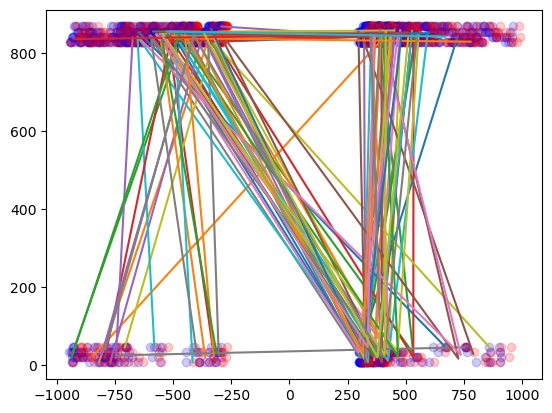

In [20]:
fig, ax=plt.subplots()
count=0
for event in cal1.values():
    ax.scatter(event['xlg'], event['zg'], color='blue', alpha=0.2)
    ax.scatter(event['xrg'], event['zg'], color='red', alpha=0.2)
    ax.plot((event.groupby('chamber').mean().reset_index()['xlg']+event.groupby('chamber').mean().reset_index()['xlg'])/2, event.groupby('chamber').mean().reset_index()['zg'], '-')
    count+=1
    if(count>=100):
        break
#ax.set_xlim(-450, -405)
plt.show()

In [21]:
fig,ax=plt.subplots(figsize=(12,7))
bins, counts=(np.unique([str(sorted(np.unique(event['chamber']))) for event in cal1.values()], return_counts=True))
zipped=zip(counts, bins)
sortedzipped=sorted(zipped, reverse=True)
print(sortedzipped)
[counts, bins]=zip(*sortedzipped)
print(bins, counts)
ax.bar(bins, counts, edgecolor='black')
fig.tight_layout()
ax.set_title('number of events for any combination of triggered chambers')

[(7344, '[0, 2]'), (6723, '[0, 1, 2]'), (4325, '[0]'), (3224, '[2]'), (2704, '[0, 1, 2, 3]'), (1865, '[0, 1]'), (1351, '[0, 2, 3]'), (1189, '[1, 2]'), (1158, '[2, 3]'), (1006, '[1]'), (805, '[3]'), (406, '[0, 3]'), (348, '[1, 2, 3]'), (262, '[0, 1, 3]'), (153, '[1, 3]')]
('[0, 2]', '[0, 1, 2]', '[0]', '[2]', '[0, 1, 2, 3]', '[0, 1]', '[0, 2, 3]', '[1, 2]', '[2, 3]', '[1]', '[3]', '[0, 3]', '[1, 2, 3]', '[0, 1, 3]', '[1, 3]') (7344, 6723, 4325, 3224, 2704, 1865, 1351, 1189, 1158, 1006, 805, 406, 348, 262, 153)


Text(0.5, 1.0, 'number of events for any combination of triggered chambers')

In [22]:
n_hits_per_event=[len(event) for event in cal1.values() if sorted(np.unique(event['chamber']))==calib_config]
print(f'average n_hits per event: {np.mean(n_hits_per_event)}')
print(f' most frequent n_hits per event {np.unique(n_hits_per_event)[np.argmax(np.unique(n_hits_per_event, return_counts=True)[1])]}')
#plt.hist(n_hits_per_event, bins=33)
plt.hist(n_hits_per_event)
print()
plt.xlabel('number of hits')
plt.ylabel('number of events')
plt.title(f'number of events vs number of hits for the {calib_config} chambers events')

average n_hits per event: 37.142011834319526
 most frequent n_hits per event 13



Text(0.5, 1.0, 'number of events vs number of hits for the [0, 1, 2, 3] chambers events')

In [23]:
'''
print(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))
print(cal1[4])
'''

"\nprint(not np.any(np.array(cal1[4].groupby('chamber').count().reset_index()['layer']<3)))\nprint(cal1[4])\n"

In [24]:
print(list((np.abs(event['xleft']-event['xright'])>XCELL).index))
print(cal1[1].index)

[0, 1, 2, 3, 4]
RangeIndex(start=0, stop=8, step=1)


In [25]:
#filters for event selection

def desired_chamber_config(event):
    return sorted(np.unique(event['chamber']))==calib_config

def three_layers_per_det(event):
    return not np.any(event[event['valid_hit']==True].groupby('chamber')['layer'].nunique().reset_index()['layer']<3)

def one_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']!=1)

def max_two_hit_per_layer(event):
    return not np.any(event.groupby(['chamber', 'layer']).count().reset_index()['time']>2)

#filters for (bad) hit selection

def coordinates_outside_cell(event):
    return list(event[np.abs(event['xleft']-event['xright'])>XCELL].index)

def deviant_hit(event): 
    n_sigmas_treshhold=2
    bad_indices=[]
    def other_hits_mu_std(out_index, event):
        index=list(event[event['chamber']==event.loc[out_index]['chamber']].index)
        index.remove(out_index)
        print('index', index)
        return event.loc[index]['center'].mean(), event.loc[index]['center'].std() 
        
    for out_index, row in event.iterrows():
        print('out_index', out_index)
        mu, std=other_hits_mu_std(out_index, event)
        print(row['center'], mu, abs(row['center']-mu), n_sigmas_treshhold*std, XCELL)
        if abs(row['center']-mu)> max(n_sigmas_treshhold*std, XCELL):
            bad_indices.append(out_index)
    return bad_indices

#filter applicators:

def event_filter(keys_list, e_filter): #modifies the list of keys
    return list(filter(lambda key : e_filter(cal1[key]), keys_list))

def hit_filter(keys_list, h_filter): #modifies in place the 'valid_hit' column of dataset
    for key in keys_list:
        event=cal1[key]
        #the "bad" filters return lists of "bad" hit indices, to be set to false. So the lists can just be concatenate with "+"
        bad_rows_indices_list=h_filter(event)
        print('badrowsindes: ',key, bad_rows_indices_list)
        #print('before:', event)
        event.loc[bad_rows_indices_list,'valid_hit'] = False
        #print('after:', event)

#FILTERS APPLICATION (both event_filters and hit_filters):
#NB: THE ORDER MATTERS!
impeccable_events=event_filter(cal1, desired_chamber_config)
impeccable_events=event_filter(impeccable_events, one_hit_per_layer)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, coordinates_outside_cell)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
hit_filter(impeccable_events, deviant_hit)
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")
impeccable_events=event_filter(impeccable_events, three_layers_per_det)

print(impeccable_events)
print(len(impeccable_events))
print(f"ratio between impeccable events and nonzerohit events {len(impeccable_events)/len(cal1)}\n", f"ratio between impeccable events and original dataset events {len(impeccable_events)/original_data_length}")

ratio between impeccable events and nonzerohit events 0.015458113988375986
 ratio between impeccable events and original dataset events 0.012304413118248316
badrowsindes:  19 []
badrowsindes:  95 []
badrowsindes:  273 []
badrowsindes:  334 []
badrowsindes:  352 []
badrowsindes:  360 []
badrowsindes:  534 []
badrowsindes:  803 []
badrowsindes:  806 []
badrowsindes:  825 [0]
badrowsindes:  862 []
badrowsindes:  886 []
badrowsindes:  967 []
badrowsindes:  971 [0, 2]
badrowsindes:  1355 []
badrowsindes:  1473 []
badrowsindes:  1487 []
badrowsindes:  1521 []
badrowsindes:  1522 [3, 7, 8]
badrowsindes:  1851 [0, 3, 4]
badrowsindes:  1876 [6]
badrowsindes:  1886 [0]
badrowsindes:  1891 []
badrowsindes:  2092 [0, 1, 2, 6, 10]
badrowsindes:  2336 []
badrowsindes:  2429 []
badrowsindes:  2444 []
badrowsindes:  2536 []
badrowsindes:  2869 []
badrowsindes:  3015 []
badrowsindes:  3117 []
badrowsindes:  3171 []
badrowsindes:  3219 []
badrowsindes:  3369 [7]
badrowsindes:  3393 [3]
badrowsindes:  35

In [26]:

event=cal1[4944]
#print( 'mu std', event.loc[[7,8,9]]['center'].mean(), event.loc[[7,8,9]]['center'].std() )
print(event)
print()
hit_filter([4944], coordinates_outside_cell)
#event_plotter(2)
print(coordinates_outside_cell(event))
print(event)


    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         1      3  188.90  189.10    2.0  758.50  758.30   19.5   758.4   
1         2      2  501.10  506.90   54.0 -768.50 -774.30  856.0  -771.4   
2         2      2  457.70  466.30   80.0 -725.10 -733.70  856.0  -729.4   
3         2      4  283.20  304.80  200.0 -550.60 -572.20  830.0  -561.4   
4         2      4  456.00  468.00  111.0 -723.40 -735.40  830.0  -729.4   
5         2      1  466.30  499.70  310.0 -733.70 -767.10  869.0  -750.4   
6         2      3  470.40  495.60  235.0 -737.80 -763.00  843.0  -750.4   
7         2      2  441.70  482.30  377.0 -709.10 -749.70  856.0  -729.4   
8         3      2  377.10  378.90   16.0 -638.60 -640.40   32.5  -639.5   
9         3      1  440.70  441.30    6.0 -702.20 -702.80   45.5  -702.5   
10        3      4  504.00  504.00   -3.0 -765.50 -765.50    6.5  -765.5   
11        3      3  438.10  443.90   54.0 -699.60 -705.40   19.5  -702.5   
12        3 

In [27]:
'''
print(cal1[4944].groupby('chamber')['layer'].nunique().reset_index())
print(cal1[4944])
'''

"\nprint(cal1[4944].groupby('chamber')['layer'].nunique().reset_index())\nprint(cal1[4944])\n"

In [28]:
from itertools import product
from scipy.stats import pearsonr
from math import atan2


def angle(A,B, C=None):
    #takes two points A and B with coordinates A=(xA,yA)... and return the angle on the plane in radiants
    #OR takes three points A, B, C with coordinates A=(xA,yA).. and return the difference angle BC^-AB^
    if C==None:
        return np.pi/2-atan2(A[1]-B[1], A[0]-B[0])
    else:
        return angle(B,C)-angle(A,B)

def zigzaginess(path):
    if(len(path)>=3):
        squaresum=0
        for i in range(len(path)-2):
            A=path[i]
            B=path[i+1]
            C=path[i+2]
            squaresum+=(angle(A,B,C))**2
        return squaresum
    else:
        print("Error: path of less than 3 points")
        return "error"

def opt_track(event, chamber):
    valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]
    valid_subevent=valid_subevent.sort_values(by='zg')
    axes=[['xrg', 'xlg']]*len(valid_subevent)
    xcs=list(product(*axes))
    paths=[[(np.array(valid_subevent[xc[i]])[i], np.array(valid_subevent['zg'])[i] ) for i in range(len(valid_subevent))] for xc in xcs]
    #sorting_function=(lambda path : abs(pearsonr(*zip(*path)).pvalue))
    #sorting_function=(lambda path : abs(np.corrcoef(*zip(*path))[0,1]))
    straightness_function=lambda x: -zigzaginess(x)
    best_path=max(paths, key=straightness_function)
    return best_path

0
95
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      1  604.200  613.80   90.0  390.000  380.40  869.0  385.2000   
1         0      2  624.900  635.10   96.0  369.300  359.10  856.0  364.2000   
2         0      4  625.900  634.10   76.0  368.300  360.10  830.0  364.2000   
3         0      3  593.700  624.30  285.0  400.500  369.90  843.0  385.2000   
4         1      3  607.400  610.60   30.0  340.000  336.80   19.5  338.4000   
5         1      2  625.200  634.80   89.0  322.200  312.60   32.5  317.4000   
6         1      1  599.100  618.90  185.0  348.300  328.50   45.5  338.4000   
7         1      2  570.000  606.00  334.0  377.400  341.40   32.5  359.4000   
8         1      4  568.900  607.10  356.0  378.500  340.30    6.5  359.4000   
9         2      1   59.790   66.21   60.0 -327.190 -333.61  869.0 -330.4000   
10        2      3   60.510   65.49   46.0 -327.910 -332.89  843.0 -330.4000   
11        2      2   67.370  100.60

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


1
273
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  629.70  630.30    6.0  364.50  363.90  856.0   364.2   
1         0      4  628.60  631.40   26.0  365.60  362.80  830.0   364.2   
2         0      2  653.80  690.20  337.0  340.40  304.00  856.0   322.2   
3         0      3  631.50  670.50  363.0  362.70  323.70  843.0   343.2   
4         1      1  607.30  610.70   32.0  340.10  336.70   45.5   338.4   
5         1      3  602.20  615.80  127.0  345.20  331.60   19.5   338.4   
6         1      2  616.50  643.50  250.0  330.90  303.90   32.5   317.4   
7         1      4  616.60  643.40  249.0  330.80  304.00    6.5   317.4   
8         2      3   59.70   66.30   61.0 -327.10 -333.70  843.0  -330.4   
9         2      1   60.24   65.76   51.0 -327.64 -333.16  869.0  -330.4   
10        2      4   26.58   57.42  286.0 -293.98 -324.82  830.0  -309.4   
11        2      2   25.01   58.99  316.0 -292.41 -326.39  856.0  -309.4   
12    

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


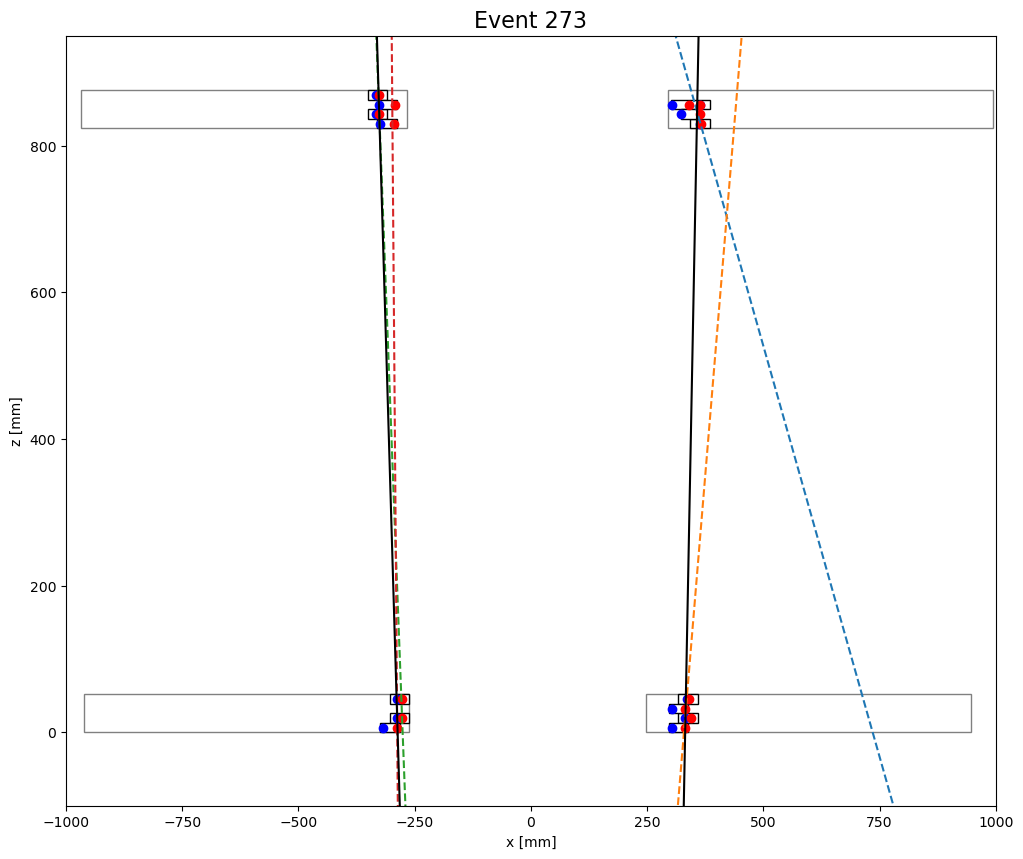

2
1487
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  643.60  658.40  137.0  350.60  335.80  869.0   343.2   
1         0      2  615.80  644.20  264.0  378.40  350.00  856.0   364.2   
2         0      3  644.80  657.20  116.0  349.40  337.00  843.0   343.2   
3         1      2  629.80  630.20    3.0  317.60  317.20   32.5   317.4   
4         1      4  629.00  631.00   18.0  318.40  316.40    6.5   317.4   
5         1      1  590.10  627.90  351.0  357.30  319.50   45.5   338.4   
6         2      4   31.20   52.80  200.0 -298.60 -320.20  830.0  -309.4   
7         2      1   54.27   71.73  162.0 -321.67 -339.13  869.0  -330.4   
8         2      2   29.99   54.01  223.0 -297.39 -321.41  856.0  -309.4   
9         3      3   15.63   26.37  100.0 -277.13 -287.87   19.5  -282.5   
10        3      1   14.47   27.53  121.0 -275.97 -289.03   45.5  -282.5   
11        3      2   28.47   55.53  251.0 -289.97 -317.03   32.5  -303.5   
12   

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


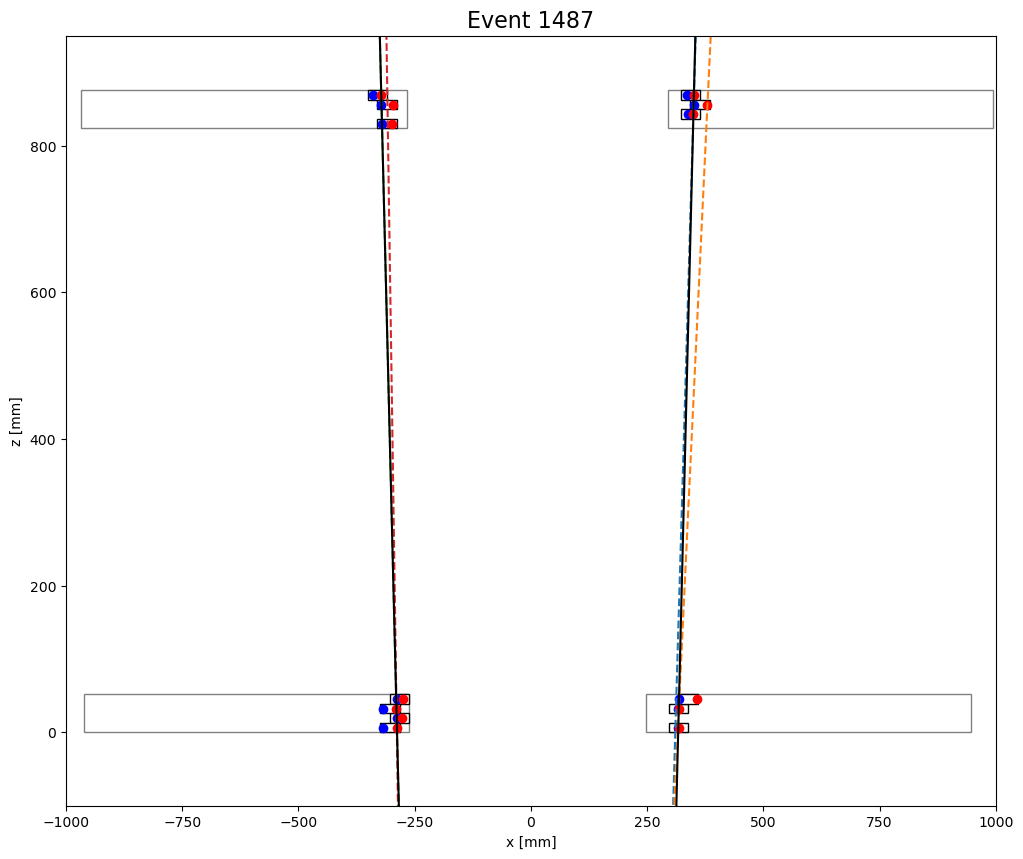

3
2429
    chamber  layer  xleft  xright   time    xrg    xlg     zg  center  \
0         0      1  395.5   402.5   66.0  598.7  591.7  869.0   595.2   
1         0      3  523.9   526.1   20.0  470.3  468.1  843.0   469.2   
2         0      3  391.7   406.3  136.0  602.5  587.9  843.0   595.2   
3         0      4  409.8   430.2  189.0  584.4  564.0  830.0   574.2   
4         1      3  313.4   316.6   30.0  634.0  630.8   19.5   632.4   
5         1      1  305.0   325.0  186.0  642.4  622.4   45.5   632.4   
6         1      2  277.9   310.1  300.0  669.5  637.3   32.5   653.4   
7         2      4  166.8   169.2   23.0 -434.2 -436.6  830.0  -435.4   
8         2      1  353.3   360.7   69.0 -620.7 -628.1  869.0  -624.4   
9         2      3  136.7   157.3  190.0 -404.1 -424.7  843.0  -414.4   
10        2      3  357.0   357.0   -3.0 -624.4 -624.4  843.0  -624.4   
11        2      2  361.3   394.7  310.0 -628.7 -662.1  856.0  -645.4   
12        2      4  318.3   353.7  329.0 -58

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


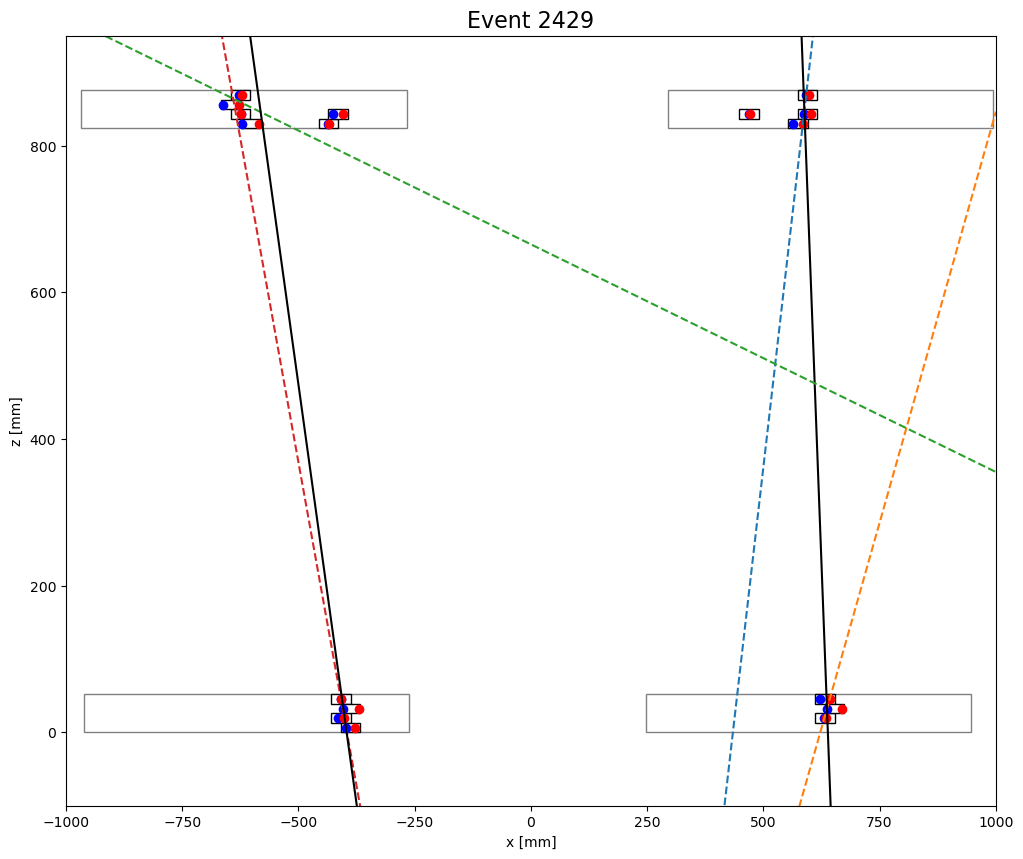

4
2536
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      4  629.200  630.80   16.0  365.000  363.40  830.0  364.2000   
1         0      2  629.000  631.00   18.0  365.200  363.20  856.0  364.2000   
2         0      2  667.600  676.40   81.0  326.600  317.80  856.0  322.2000   
3         0      4  666.500  677.50  102.0  327.700  316.70  830.0  322.2000   
4         0      1  589.300  628.70  366.0  404.900  365.50  869.0  385.2000   
5         1      2  626.300  633.70   69.0  321.100  313.70   32.5  317.4000   
6         1      4  628.200  631.80   34.0  319.200  315.60    6.5  317.4000   
7         1      1  593.100  624.90  295.0  354.300  322.50   45.5  338.4000   
8         1      3  592.100  625.90  313.0  355.300  321.50   19.5  338.4000   
9         2      2   81.680   86.32   43.0 -349.080 -353.72  856.0 -351.4000   
10        2      1    8.992   33.01  223.0 -276.392 -300.41  869.0 -288.4010   
11        2      4   82.000   86.

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


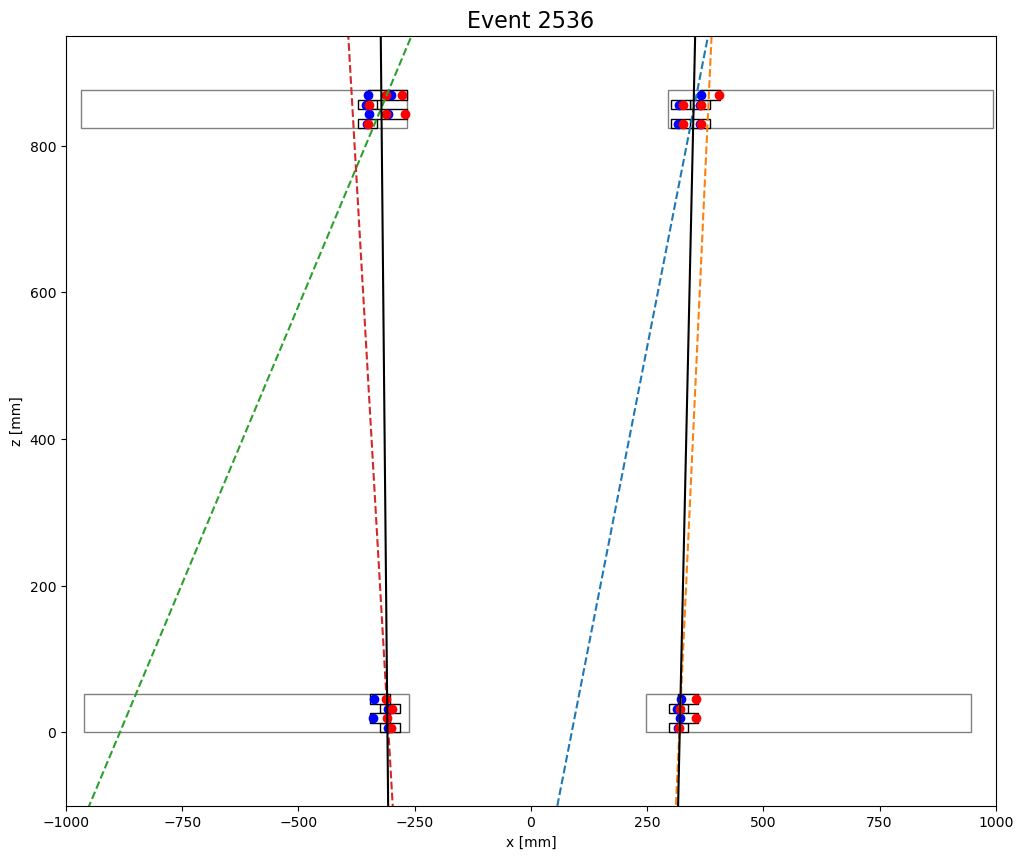

5
4755
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  482.20  483.80   16.0  512.00  510.40  869.0  511.200   
1         0      3  482.70  483.30    6.0  511.50  510.90  843.0  511.200   
2         0      1  561.40  572.60  104.0  432.80  421.60  869.0  427.200   
3         0      4  490.10  517.90  259.0  504.10  476.30  830.0  490.200   
4         0      3  558.40  575.60  159.0  435.80  418.60  843.0  427.200   
5         1      1  605.20  612.80   70.0  342.20  334.60   45.5  338.400   
6         1      4  576.50  599.50  213.0  370.90  347.90    6.5  359.400   
7         1      3  602.00  616.00  130.0  345.40  331.40   19.5  338.400   
8         1      4  621.90  638.10  150.0  325.50  309.30    6.5  317.400   
9         1      2  620.00  640.00  186.0  327.40  307.40   32.5  317.400   
10        2      2   82.22   85.78   33.0 -349.62 -353.18  856.0 -351.400   
11        2      4   83.75   84.25    5.0 -351.15 -351.65  830.0 -351

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


6
5642
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  627.10  632.90   54.0  367.10  361.30  856.0   364.2   
1         0      4  628.30  631.70   32.0  365.90  362.50  830.0   364.2   
2         0      1  593.10  624.90  296.0  401.10  369.30  869.0   385.2   
3         0      3  592.20  625.80  311.0  402.00  368.40  843.0   385.2   
4         1      1  607.10  610.90   36.0  340.30  336.50   45.5   338.4   
5         1      4  503.30  504.70   13.0  444.10  442.70    6.5   443.4   
6         1      3  605.30  612.70   69.0  342.10  334.70   19.5   338.4   
7         1      4  615.80  644.20  263.0  331.60  303.20    6.5   317.4   
8         1      2  614.30  645.70  292.0  333.10  301.70   32.5   317.4   
9         2      3  102.30  107.70   50.0 -369.70 -375.10  843.0  -372.4   
10        2      3  256.50  289.50  307.0 -523.90 -556.90  843.0  -540.4   
11        2      2  110.90  141.10  280.0 -378.30 -408.50  856.0  -393.4   
12   

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


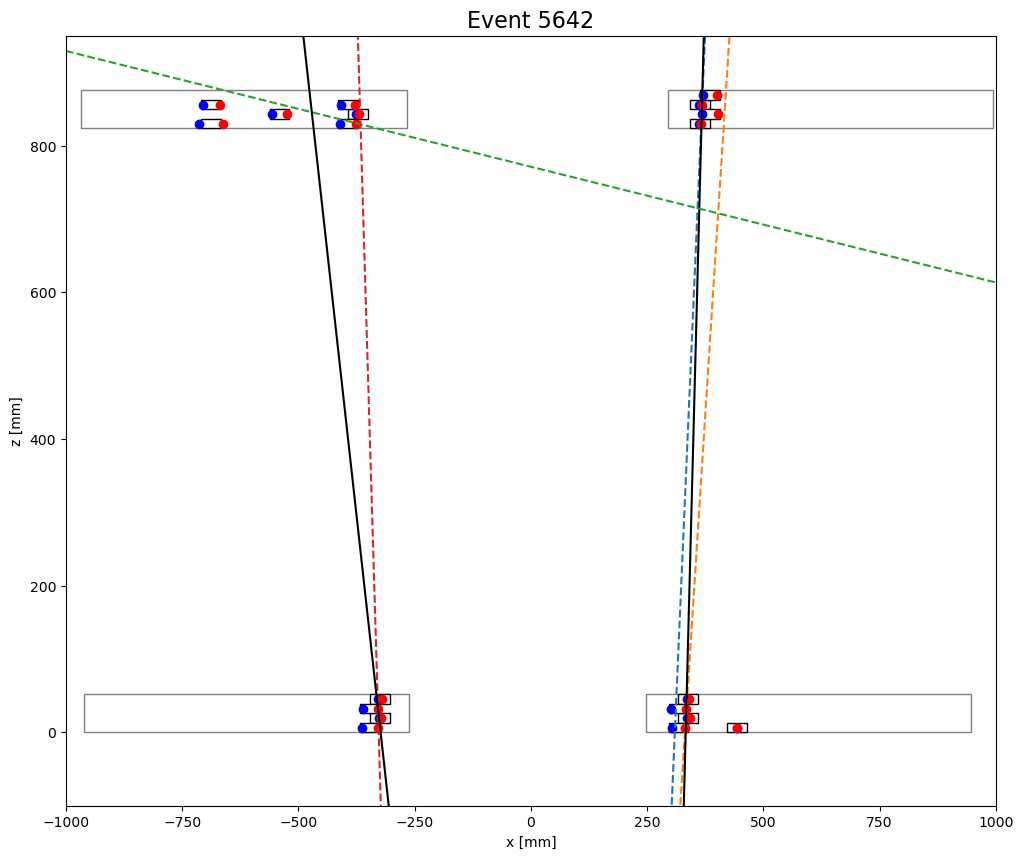

7
6577
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      4  587.20  588.80   15.0  407.00  405.40  830.0  406.200   
1         0      1  549.40  584.60  326.0  444.80  409.60  869.0  427.200   
2         0      3  549.10  584.90  332.0  445.10  409.30  843.0  427.200   
3         1      4  579.50  596.50  157.0  367.90  350.90    6.5  359.400   
4         1      1  558.00  576.00  168.0  389.40  371.40   45.5  380.400   
5         1      3  556.30  577.70  198.0  391.10  369.70   19.5  380.400   
6         1      2  576.30  599.70  217.0  371.10  347.70   32.5  359.400   
7         2      4   79.58   88.42   82.0 -346.98 -355.82  830.0 -351.400   
8         2      2   78.37   89.63  105.0 -345.77 -357.03  856.0 -351.400   
9         2      3   90.57  119.40  268.0 -357.97 -386.80  843.0 -372.385   
10        3      1   62.57   63.43    8.0 -324.07 -324.93   45.5 -324.500   
11        3      3   61.27   64.73   32.0 -322.77 -326.23   19.5 -324

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


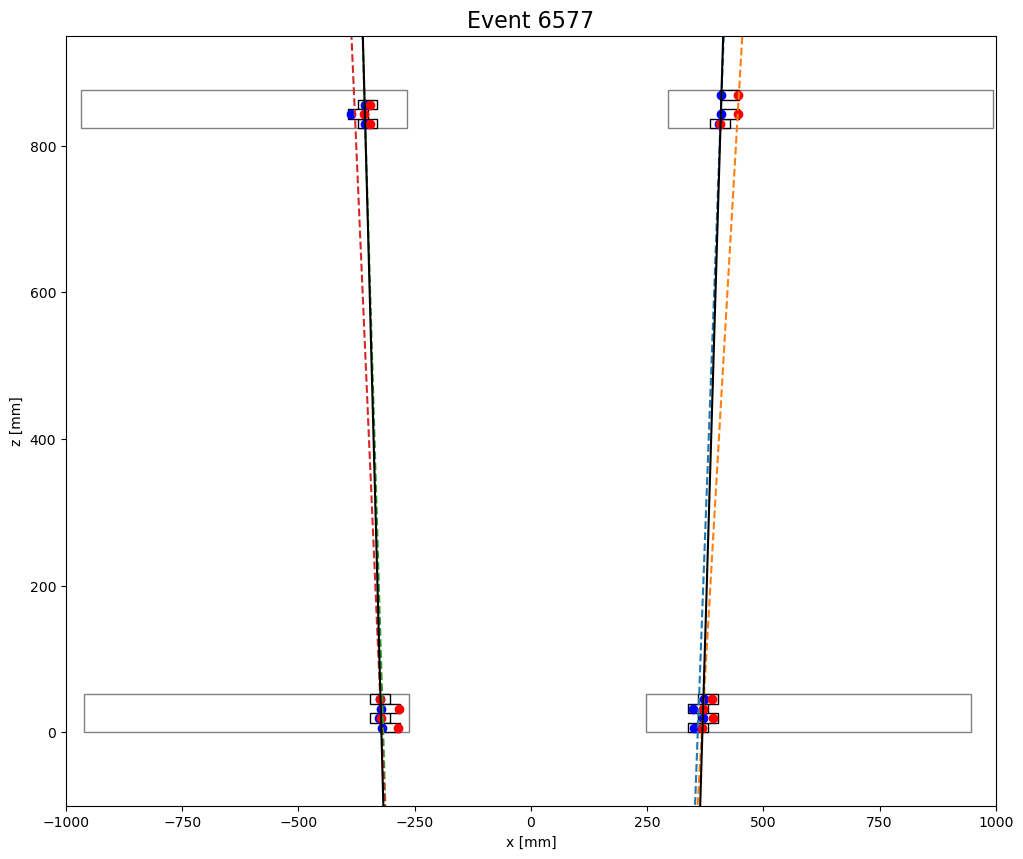

8
8556
    chamber  layer    xleft  xright   time      xrg     xlg     zg   center  \
0         0      1  601.000  617.00  148.0  393.200  377.20  869.0  385.200   
1         0      3  599.400  618.60  179.0  394.800  375.60  843.0  385.200   
2         0      2  616.700  643.30  247.0  377.500  350.90  856.0  364.200   
3         0      4  619.800  640.20  189.0  374.400  354.00  830.0  364.200   
4         1      1  604.800  613.20   79.0  342.600  334.20   45.5  338.400   
5         1      3  603.100  614.90  110.0  344.300  332.50   19.5  338.400   
6         1      4  616.800  643.20  246.0  330.600  304.20    6.5  317.400   
7         1      2  615.200  644.80  275.0  332.200  302.60   32.5  317.400   
8         2      2   76.350   91.65  142.0 -343.750 -359.05  856.0 -351.400   
9         2      1   50.950   75.05  224.0 -318.350 -342.45  869.0 -330.400   
10        2      4   75.310   92.69  161.0 -342.710 -360.09  830.0 -351.400   
11        2      3   52.030   73.97  204.0 -3

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


9
8859
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  624.10  635.90  110.0  370.10  358.30  856.0   364.2   
1         0      4  625.70  634.30   80.0  368.50  359.90  830.0   364.2   
2         0      1  595.60  622.40  248.0  398.60  371.80  869.0   385.2   
3         1      4  627.80  632.20   41.0  319.60  315.20    6.5   317.4   
4         1      1  599.50  618.50  176.0  347.90  328.90   45.5   338.4   
5         1      3  598.20  619.80  200.0  349.20  327.60   19.5   338.4   
6         2      1   21.00   21.00   -6.0 -288.40 -288.40  869.0  -288.4   
7         2      3  101.20  108.80   70.0 -368.60 -376.20  843.0  -372.4   
8         2      3   19.09   22.91   36.0 -286.49 -290.31  843.0  -288.4   
9         2      2  110.60  141.40  286.0 -378.00 -408.80  856.0  -393.4   
10        2      4  109.10  142.90  313.0 -376.50 -410.30  830.0  -393.4   
11        3      2   76.79   91.21  134.0 -338.29 -352.71   32.5  -345.5   
12   

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


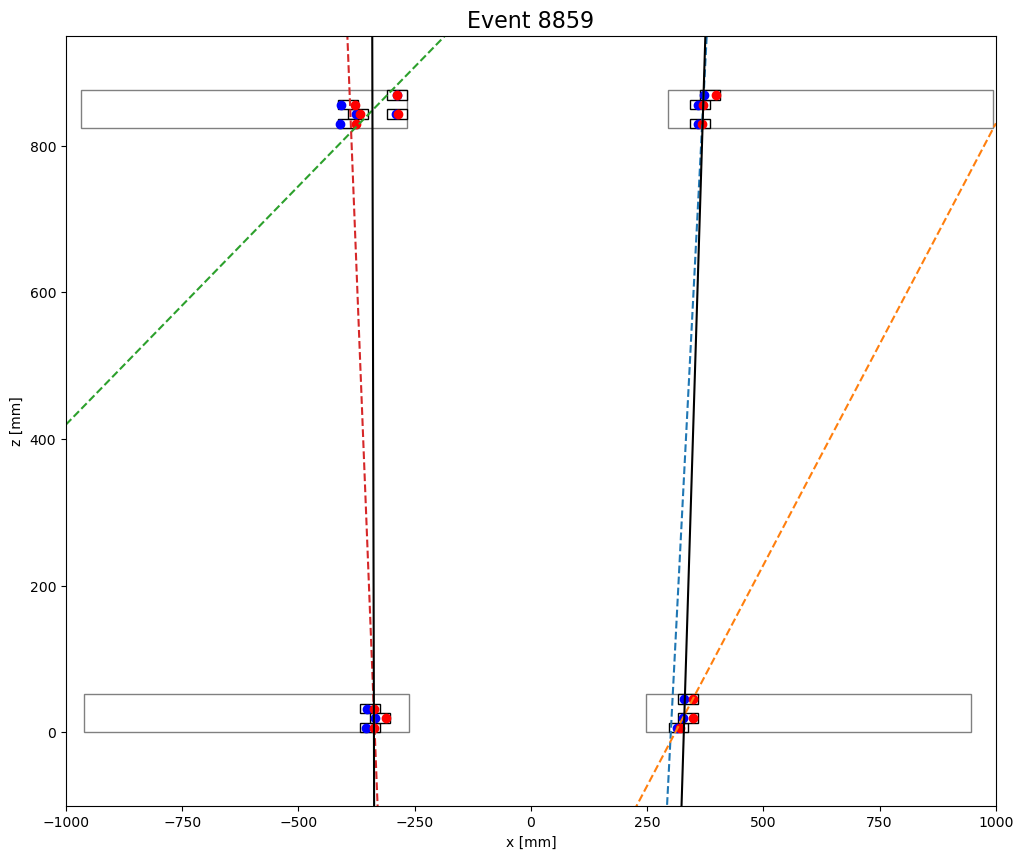

10
9351
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1   11.06   30.94  185.0  983.14  963.26  869.0   973.2   
1         0      1  597.80  620.20  207.0  396.40  374.00  869.0   385.2   
2         0      4  619.30  640.70  199.0  374.90  353.50  830.0   364.2   
3         0      3  594.00  624.00  279.0  400.20  370.20  843.0   385.2   
4         1      1  221.10  240.90  184.0  726.30  706.50   45.5   716.4   
5         1      2  240.90  263.10  206.0  706.50  684.30   32.5   695.4   
6         1      3  214.10  247.90  313.0  733.30  699.50   19.5   716.4   
7         1      2  229.30  274.70  422.0  718.10  672.70   32.5   695.4   
8         2      3  558.40  575.60  159.0 -825.80 -843.00  843.0  -834.4   
9         2      2  579.90  596.10  150.0 -847.30 -863.50  856.0  -855.4   
10        2      1  551.80  582.20  283.0 -819.20 -849.60  869.0  -834.4   
11        2      4  573.70  602.30  265.0 -841.10 -869.70  830.0  -855.4   
12  

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


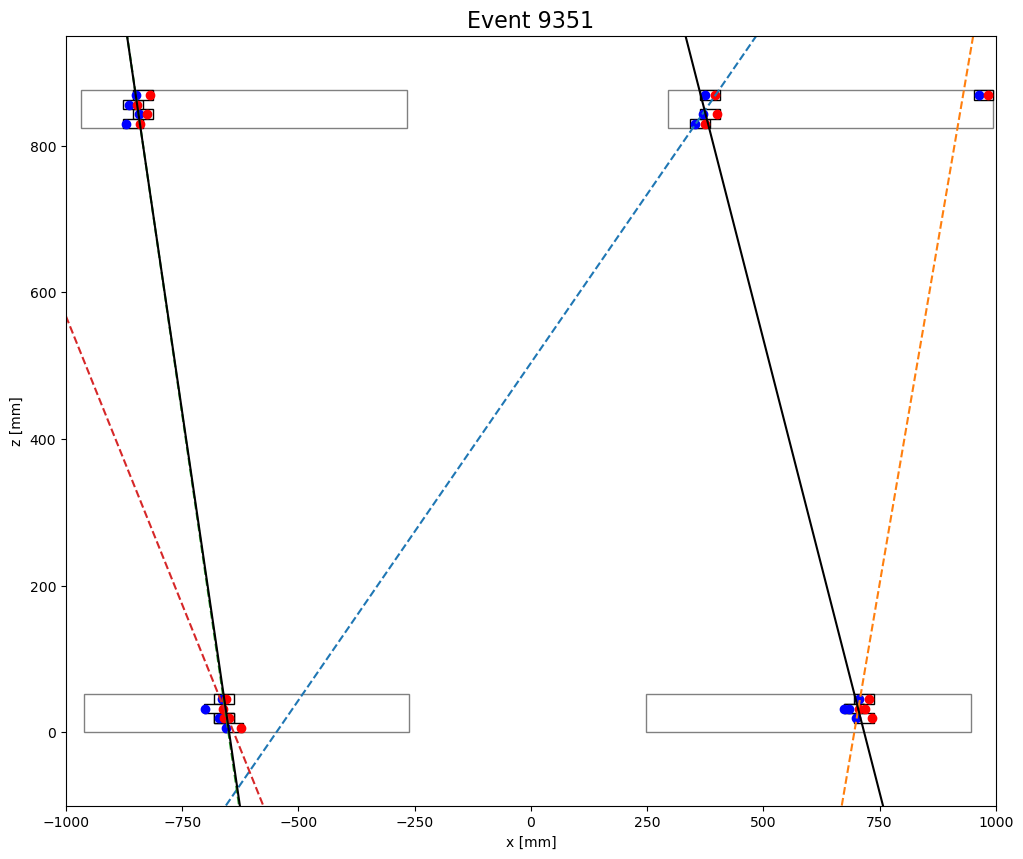

11
9523
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  625.30  634.70   88.0  368.90  359.50  856.0   364.2   
1         0      4  627.00  633.00   56.0  367.20  361.20  830.0   364.2   
2         0      1  593.60  624.40  286.0  400.60  369.80  869.0   385.2   
3         0      3  592.70  625.30  303.0  401.50  368.90  843.0   385.2   
4         1      4  626.20  633.80   71.0  321.20  313.60    6.5   317.4   
5         1      2  624.30  635.70  106.0  323.10  311.70   32.5   317.4   
6         1      1  595.80  622.20  245.0  351.60  325.20   45.5   338.4   
7         1      3  594.30  623.70  274.0  353.10  323.70   19.5   338.4   
8         2      1   61.94   64.06   20.0 -329.34 -331.46  869.0  -330.4   
9         2      3   57.63   68.37  100.0 -325.03 -335.77  843.0  -330.4   
10        2      2   76.88   91.12  132.0 -344.28 -358.52  856.0  -351.4   
11        2      4   76.03   91.97  148.0 -343.43 -359.37  830.0  -351.4   
12  

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


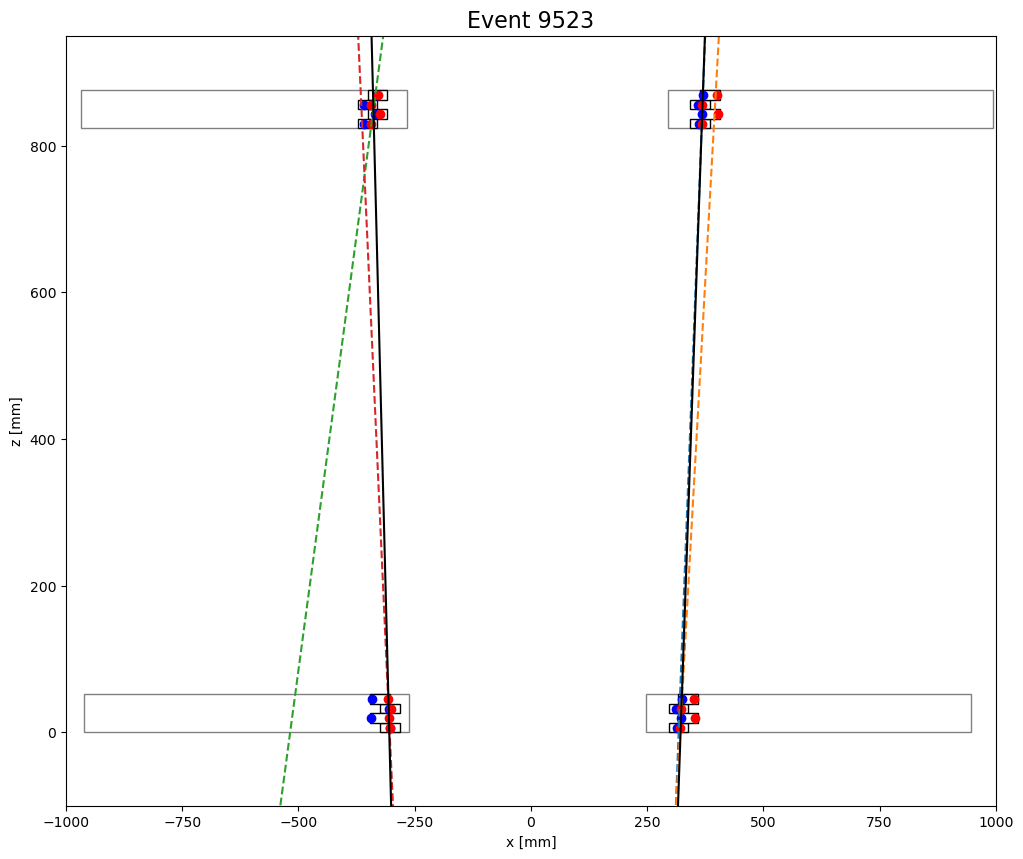

12
9525
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      4  578.00  598.00  186.0  416.20  396.20  830.0  406.200   
1         0      3  597.30  620.70  218.0  396.90  373.50  843.0  385.200   
2         0      1  596.50  621.50  232.0  397.70  372.70  869.0  385.200   
3         1      3  600.80  617.20  151.0  346.60  330.20   19.5  338.400   
4         1      2  577.20  598.80  200.0  370.20  348.60   32.5  359.400   
5         1      1  598.60  619.40  194.0  348.80  328.00   45.5  338.400   
6         2      4   78.05   89.95  110.0 -345.45 -357.35  830.0 -351.400   
7         2      2   76.84   91.16  133.0 -344.24 -358.56  856.0 -351.400   
8         2      3   91.69  118.30  247.0 -359.09 -385.70  843.0 -372.395   
9         3      4   41.61   42.39    7.0 -303.11 -303.89    6.5 -303.500   
10        3      3   53.19   72.81  182.0 -314.69 -334.31   19.5 -324.500   
11        3      2   31.29   52.71  199.0 -292.79 -314.21   32.5 -30

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


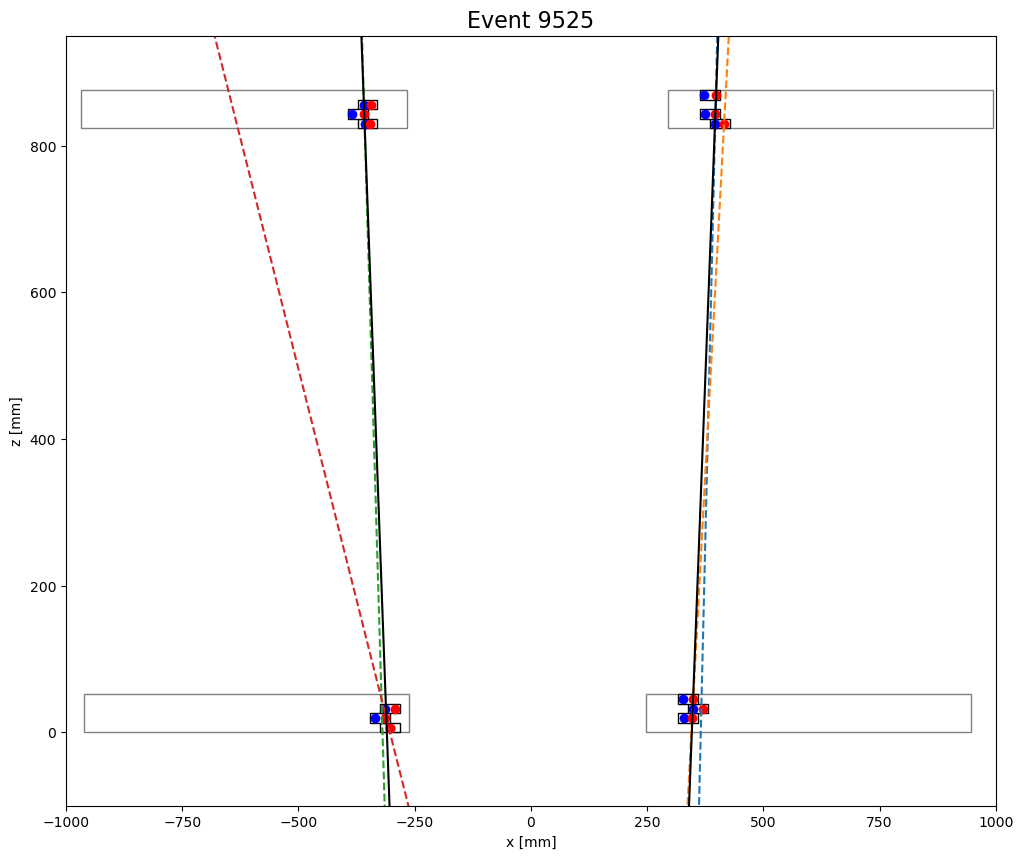

13
9593
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  600.50  617.50  157.0  393.70  376.70  869.0   385.2   
1         0      3  598.10  619.90  202.0  396.10  374.30  843.0   385.2   
2         0      2  618.60  641.40  211.0  375.60  352.80  856.0   364.2   
3         0      4  620.30  639.70  180.0  373.90  354.50  830.0   364.2   
4         1      1  609.00  609.00   -0.0  338.40  338.40   45.5   338.4   
5         1      3  608.10  609.90   16.0  339.30  337.50   19.5   338.4   
6         1      4  611.60  648.40  341.0  335.80  299.00    6.5   317.4   
7         2      2   81.37   86.63   49.0 -348.77 -354.03  856.0  -351.4   
8         2      1   51.71   74.29  210.0 -319.11 -341.69  869.0  -330.4   
9         2      4   80.43   87.57   66.0 -347.83 -354.97  830.0  -351.4   
10        2      3   46.51   79.49  306.0 -313.91 -346.89  843.0  -330.4   
11        3      4   41.43   42.57   10.0 -302.93 -304.07    6.5  -303.5   
12  

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


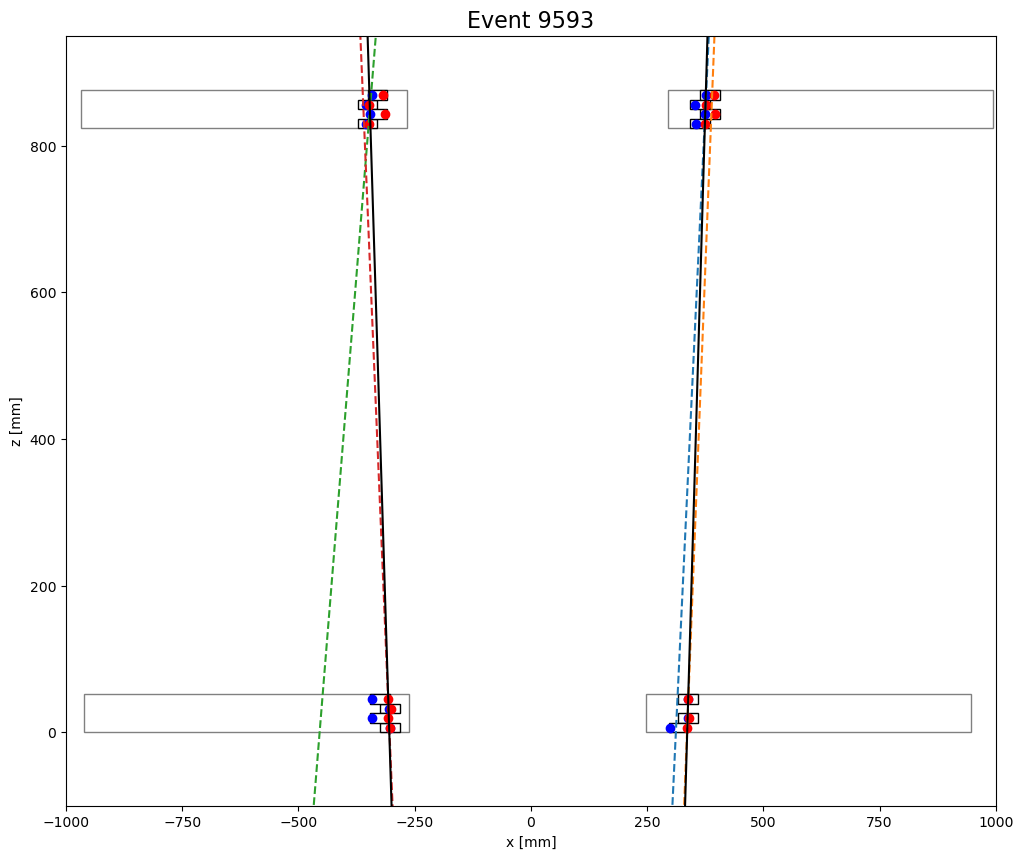

14
9775
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      3  391.50  406.50  139.0  602.70  587.70  843.0   595.2   
1         0      2  367.30  388.70  199.0  626.90  605.50  856.0   616.2   
2         0      1  386.00  412.00  242.0  608.20  582.20  869.0   595.2   
3         0      4  362.30  393.70  292.0  631.90  600.50  830.0   616.2   
4         1      4  500.50  507.50   66.0  446.90  439.90    6.5   443.4   
5         1      1  480.10  485.90   53.0  467.30  461.50   45.5   464.4   
6         1      3  475.20  490.80  145.0  472.20  456.60   19.5   464.4   
7         1      2  489.00  519.00  279.0  458.40  428.40   32.5   443.4   
8         2      2  251.00  253.00   18.0 -518.40 -520.40  856.0  -519.4   
9         2      4  245.90  258.10  114.0 -513.30 -525.50  830.0  -519.4   
10        2      3  214.40  247.60  309.0 -481.80 -515.00  843.0  -498.4   
11        3      4   35.51   48.49  120.0 -297.01 -309.99    6.5  -303.5   
12  

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


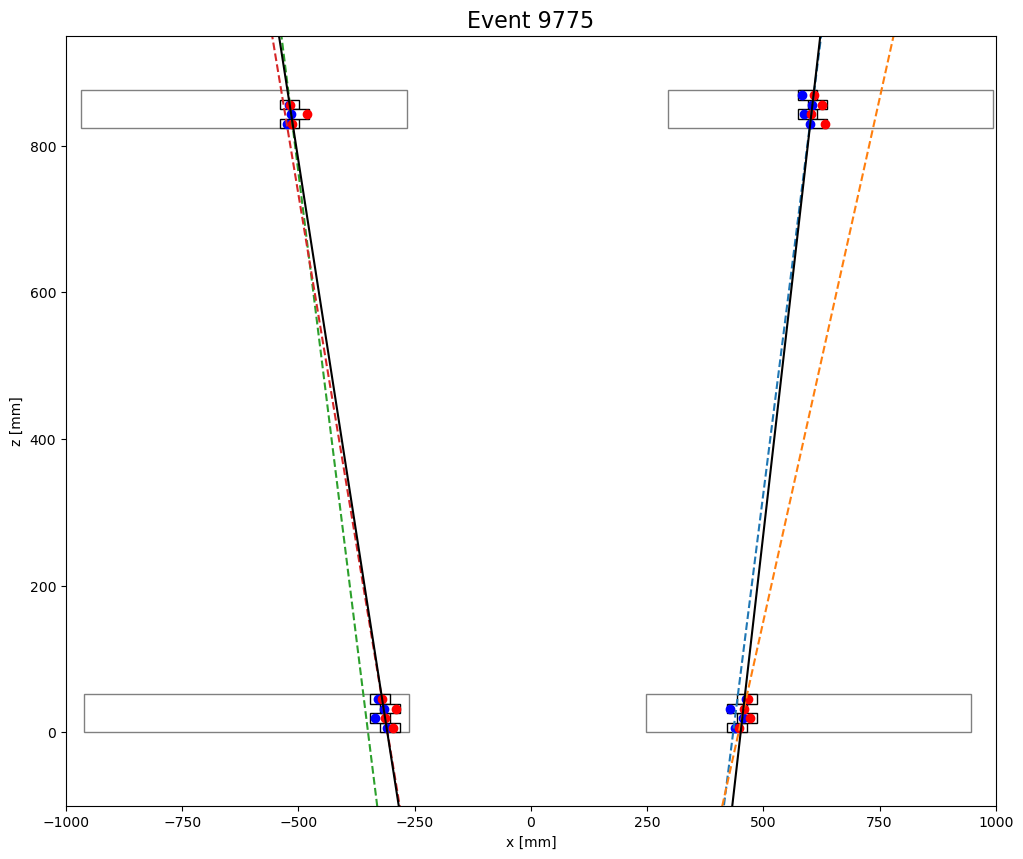

15
10475
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  602.40  615.60  122.0  391.80  378.60  869.0   385.2   
1         0      2  617.40  642.60  234.0  376.80  351.60  856.0   364.2   
2         0      1  628.10  673.90  425.0  366.10  320.30  869.0   343.2   
3         0      4  618.80  641.20  207.0  375.40  353.00  830.0   364.2   
4         0      4  647.70  696.30  452.0  346.50  297.90  830.0   322.2   
5         1      1  603.40  614.60  105.0  344.00  332.80   45.5   338.4   
6         1      3  601.90  616.10  131.0  345.50  331.30   19.5   338.4   
7         1      2  617.10  642.90  239.0  330.30  304.50   32.5   317.4   
8         1      4  618.80  641.20  208.0  328.60  306.20    6.5   317.4   
9         2      1   58.98   67.02   75.0 -326.38 -334.42  869.0  -330.4   
10        2      3   58.04   67.96   92.0 -325.44 -335.36  843.0  -330.4   
11        2      2   26.81   57.19  282.0 -294.21 -324.59  856.0  -309.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


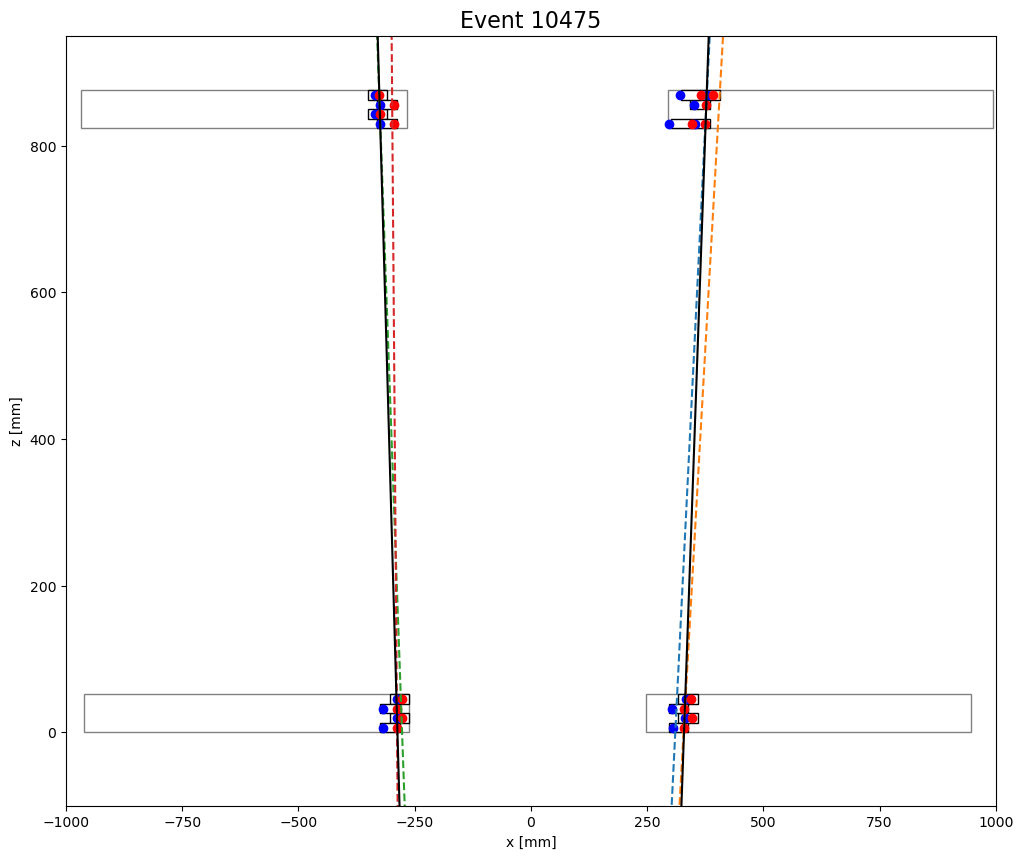

16
14573
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  561.50  572.50  102.0  432.70  421.70  869.0   427.2   
1         0      2  627.50  632.50   47.0  366.70  361.70  856.0   364.2   
2         0      1  598.10  619.90  202.0  396.10  374.30  869.0   385.2   
3         0      2  532.20  559.80  256.0  462.00  434.40  856.0   448.2   
4         0      3  596.70  621.30  229.0  397.50  372.90  843.0   385.2   
5         1      1  602.30  615.70  125.0  345.10  331.70   45.5   338.4   
6         1      3  600.40  617.60  160.0  347.00  329.80   19.5   338.4   
7         1      4  619.90  640.10  188.0  327.50  307.30    6.5   317.4   
8         1      2  618.70  641.30  210.0  328.70  306.10   32.5   317.4   
9         2      1   60.78   65.22   41.0 -328.18 -332.62  869.0  -330.4   
10        2      3   60.28   65.72   50.0 -327.68 -333.12  843.0  -330.4   
11        2      4   25.55   58.45  306.0 -292.95 -325.85  830.0  -309.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


17
15810
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  601.40  616.60  141.0  392.80  377.60  869.0   385.2   
1         0      3  597.90  620.10  206.0  396.30  374.10  843.0   385.2   
2         0      2  620.20  639.80  182.0  374.00  354.40  856.0   364.2   
3         1      1  609.00  609.00   -1.0  338.40  338.40   45.5   338.4   
4         1      3  608.60  609.40    7.0  338.80  338.00   19.5   338.4   
5         1      4  611.20  648.80  350.0  336.20  298.60    6.5   317.4   
6         2      3   60.15   65.85   53.0 -327.55 -333.25  843.0  -330.4   
7         2      1   55.93   70.07  131.0 -323.33 -337.47  869.0  -330.4   
8         2      2   70.65   97.35  248.0 -338.05 -364.75  856.0  -351.4   
9         2      4   69.48   98.52  270.0 -336.88 -365.92  830.0  -351.4   
10        3      2   40.09   43.91   36.0 -301.59 -305.41   32.5  -303.5   
11        3      4   41.07   42.93   17.0 -302.57 -304.43    6.5  -303.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


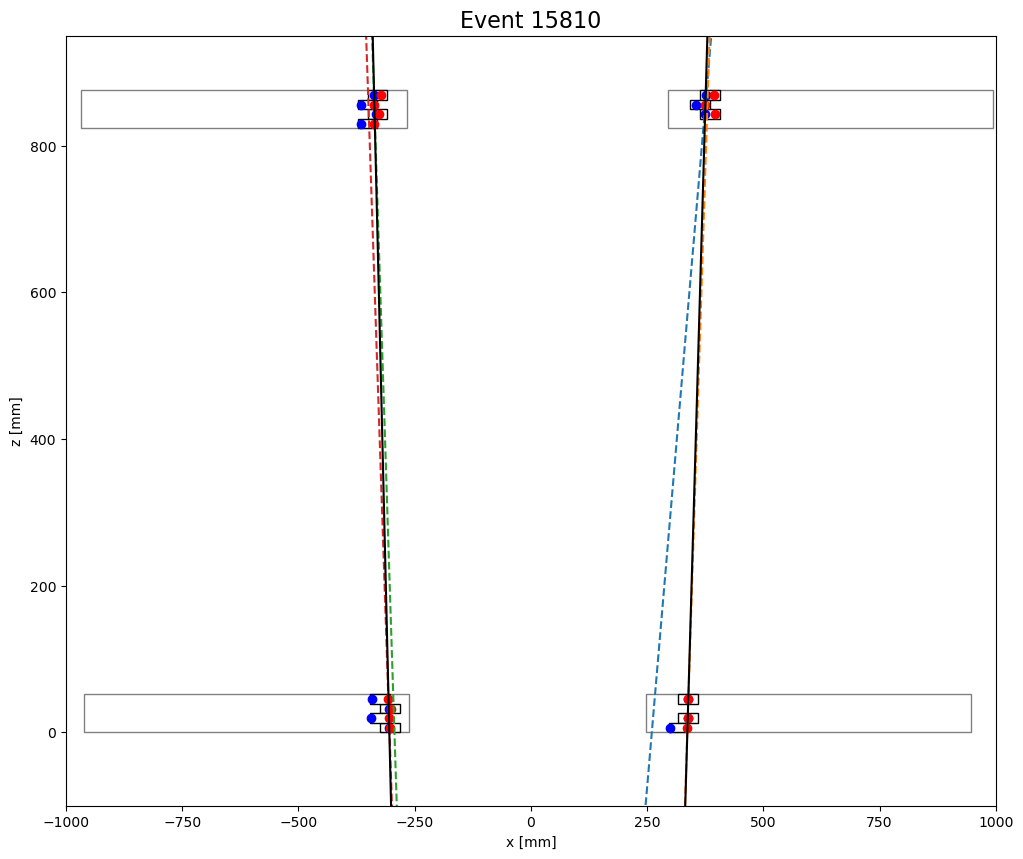

18
15823
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      2  377.300  378.70   12.0  616.900  615.50  856.0  616.2000   
1         0      1  438.400  443.60   48.0  555.800  550.60  869.0  553.2000   
2         0      4  457.900  466.10   76.0  536.300  528.10  830.0  532.2000   
3         0      4  368.100  387.90  184.0  626.100  606.30  830.0  616.2000   
4         0      2  542.600  549.40   64.0  451.600  444.80  856.0  448.2000   
5         0      3  438.700  443.30   43.0  555.500  550.90  843.0  553.2000   
6         0      1  509.400  540.60  290.0  484.800  453.60  869.0  469.2000   
7         0      3  506.600  543.40  342.0  487.600  450.80  843.0  469.2000   
8         1      2  540.000  552.00  112.0  407.400  395.40   32.5  401.4000   
9         1      4  538.000  554.00  149.0  409.400  393.40    6.5  401.4000   
10        1      1  551.600  582.40  286.0  395.800  365.00   45.5  380.4000   
11        1      3  553.700  58

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


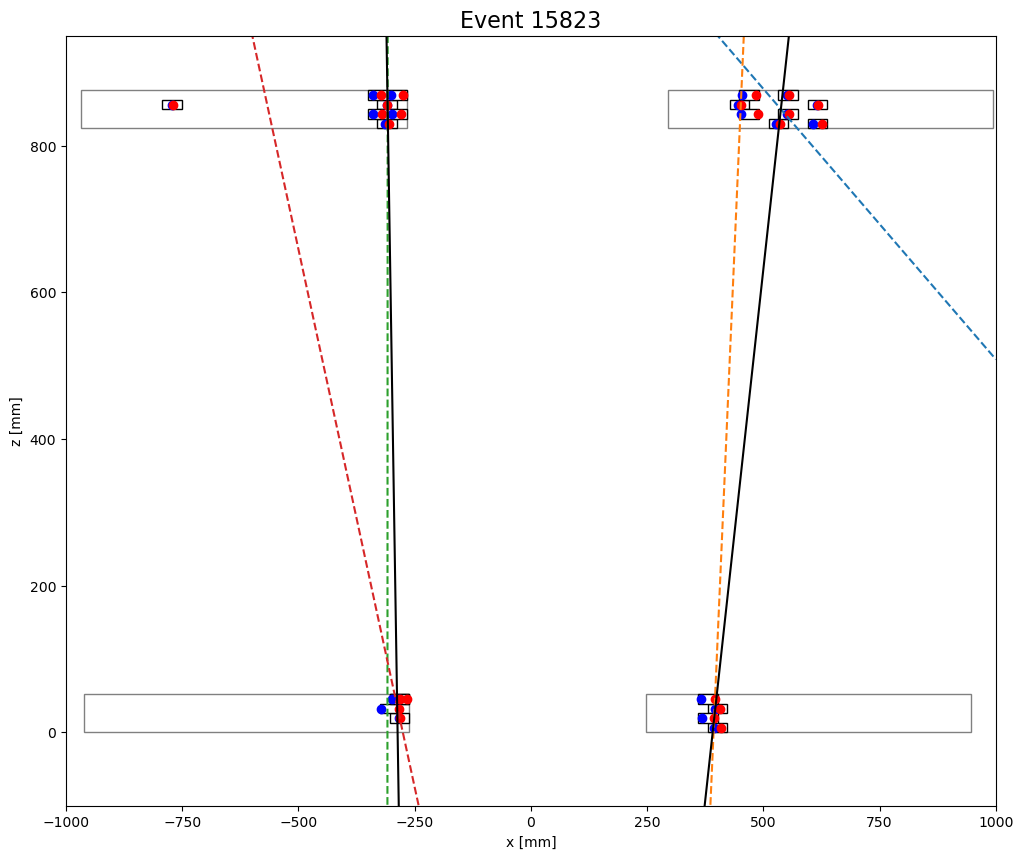

19
17222
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      4  577.60  598.40  193.0  416.60  395.80  830.0   406.2   
1         0      1  597.10  620.90  221.0  397.10  373.30  869.0   385.2   
2         0      3  599.00  619.00  186.0  395.20  375.20  843.0   385.2   
3         1      2  582.40  593.60  104.0  365.00  353.80   32.5   359.4   
4         1      4  580.90  595.10  132.0  366.50  352.30    6.5   359.4   
5         1      1  593.40  624.60  289.0  354.00  322.80   45.5   338.4   
6         1      3  595.10  622.90  258.0  352.30  324.50   19.5   338.4   
7         2      3  103.40  106.60   30.0 -370.80 -374.00  843.0  -372.4   
8         2      2  108.70  143.30  320.0 -376.10 -410.70  856.0  -393.4   
9         2      4  107.40  144.60  346.0 -374.80 -412.00  830.0  -393.4   
10        3      1   53.19   72.81  182.0 -314.69 -334.31   45.5  -324.5   
11        3      3   54.98   71.02  149.0 -316.48 -332.52   19.5  -324.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


20
17569
    chamber  layer    xleft  xright   time      xrg     xlg     zg   center  \
0         0      4  625.400  634.60   85.0  368.800  359.60  830.0  364.200   
1         0      2  624.400  635.60  105.0  369.800  358.60  856.0  364.200   
2         0      1  595.100  622.90  259.0  399.100  371.30  869.0  385.200   
3         1      1  608.000  610.00   19.0  339.400  337.40   45.5  338.400   
4         1      3  608.300  609.70   13.0  339.100  337.70   19.5  338.400   
5         1      4  610.800  649.20  357.0  336.600  298.20    6.5  317.400   
6         2      3   56.730   69.27  116.0 -324.130 -336.67  843.0 -330.400   
7         2      1  315.000  315.00  -14.0 -582.400 -582.40  869.0 -582.400   
8         2      1   53.100   72.90  184.0 -320.500 -340.30  869.0 -330.400   
9         2      4   69.790   98.21  264.0 -337.190 -365.61  830.0 -351.400   
10        3      2   33.090   50.91  166.0 -294.590 -312.41   32.5 -303.500   
11        3      1    8.992   33.01  223.0 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


21
18635
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      4  628.30  631.70   31.0  365.90  362.50  830.0  364.20   
1         0      2  626.70  633.30   61.0  367.50  360.90  856.0  364.20   
2         0      1  592.90  625.10  300.0  401.30  369.10  869.0  385.20   
3         0      3  591.20  626.80  330.0  403.00  367.40  843.0  385.20   
4         1      4  622.80  637.20  133.0  324.60  310.20    6.5  317.40   
5         1      3  597.60  620.40  212.0  349.80  327.00   19.5  338.40   
6         1      2  620.60  639.40  174.0  326.80  308.00   32.5  317.40   
7         2      2   77.20   90.80  126.0 -344.60 -358.20  856.0 -351.40   
8         2      4   77.96   90.04  112.0 -345.36 -357.44  830.0 -351.40   
9         2      3   91.56  118.40  250.0 -358.96 -385.80  843.0 -372.38   
10        3      1   59.70   66.30   61.0 -321.20 -327.80   45.5 -324.50   
11        3      3   58.31   67.69   87.0 -319.81 -329.19   19.5 -324.50   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


22
18908
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  564.30  569.70   50.0  429.90  424.50  869.0   427.2   
1         0      4  579.00  597.00  166.0  415.20  397.20  830.0   406.2   
2         0      3  596.30  621.70  236.0  397.90  372.50  843.0   385.2   
3         0      1  595.60  622.40  249.0  398.60  371.80  869.0   385.2   
4         1      2  582.00  594.00  111.0  365.40  353.40   32.5   359.4   
5         1      3  603.90  614.10   94.0  343.50  333.30   19.5   338.4   
6         1      4  579.90  596.10  150.0  367.50  351.30    6.5   359.4   
7         1      1  594.50  623.50  270.0  352.90  323.90   45.5   338.4   
8         1      2  571.50  604.50  306.0  375.90  342.90   32.5   359.4   
9         1      3  595.80  622.20  246.0  351.60  325.20   19.5   338.4   
10        2      2   81.19   86.81   52.0 -348.59 -354.21  856.0  -351.4   
11        2      4   80.07   87.93   73.0 -347.47 -355.33  830.0  -351.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


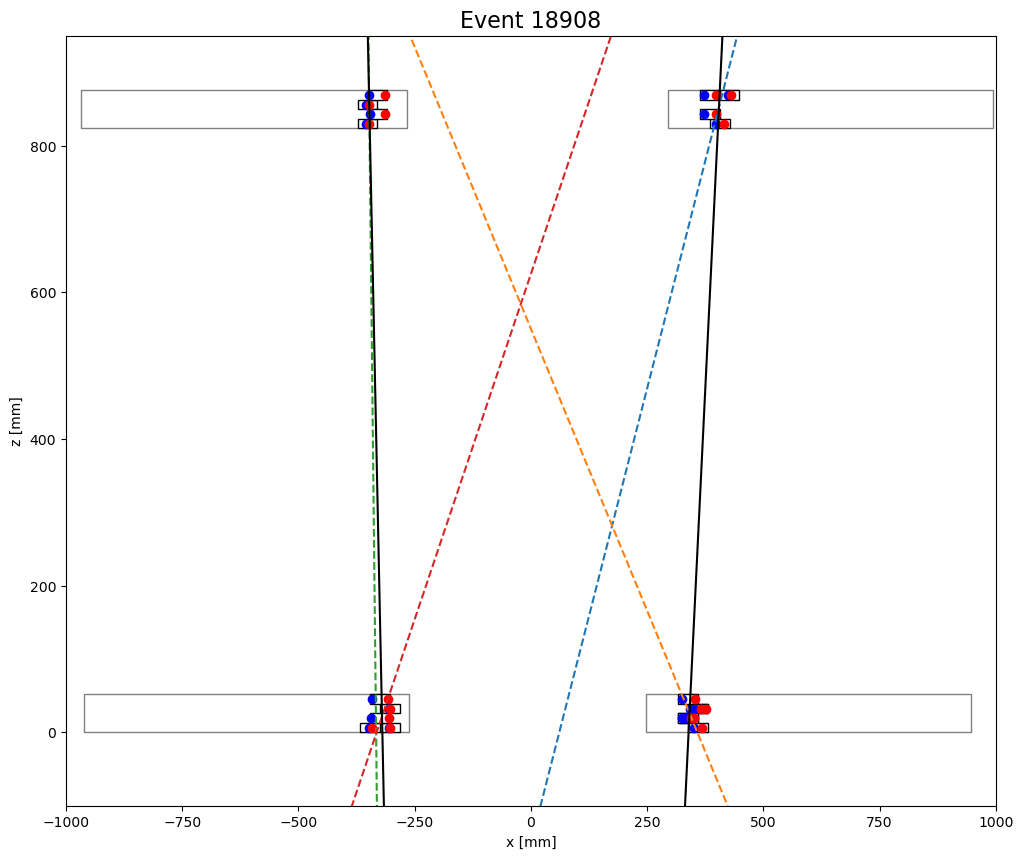

23
20154
    chamber  layer   xleft  xright   time     xrg    xlg     zg   center  \
0         0      2  625.60   634.4   82.0  368.60  359.8  856.0  364.200   
1         0      3  649.70   652.3   25.0  344.50  341.9  843.0  343.200   
2         0      4  624.00   636.0  111.0  370.20  358.2  830.0  364.200   
3         0      1  648.40   653.6   49.0  345.80  340.6  869.0  343.200   
4         0      2  611.50   648.5  344.0  382.70  345.7  856.0  364.200   
5         0      1  634.50   667.5  306.0  359.70  326.7  869.0  343.200   
6         0      4  610.50   649.5  363.0  383.70  344.7  830.0  364.200   
7         0      3  635.90   666.1  280.0  358.30  328.1  843.0  343.200   
8         1      2  629.60   630.4    7.0  317.80  317.0   32.5  317.400   
9         1      4  629.40   630.6   11.0  318.00  316.8    6.5  317.400   
10        1      1  592.50   625.5  306.0  354.90  321.9   45.5  338.400   
11        2      1  146.60   147.4    8.0 -414.00 -414.8  869.0 -414.400   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


chamber: 3


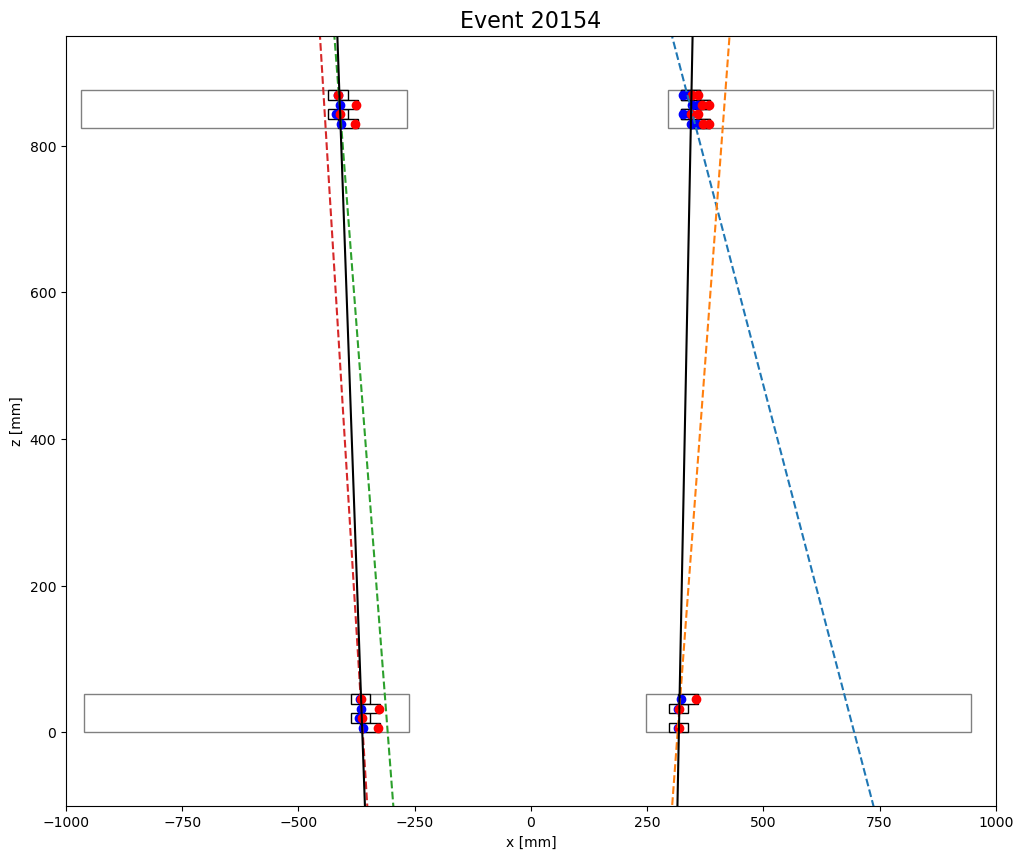

24
21230
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      2  539.30  552.70  125.0  454.90  441.50  856.0  448.200   
1         0      1  604.70  613.30   80.0  389.50  380.90  869.0  385.200   
2         0      3  555.60  578.40  212.0  438.60  415.80  843.0  427.200   
3         0      3  603.20  614.80  107.0  391.00  379.40  843.0  385.200   
4         0      1  550.80  583.20  301.0  443.40  411.00  869.0  427.200   
5         0      4  616.20  643.80  257.0  378.00  350.40  830.0  364.200   
6         1      1  609.00  609.00   -5.0  338.40  338.40   45.5  338.400   
7         1      3  606.60  611.40   45.0  340.80  336.00   19.5  338.400   
8         1      4  615.70  644.30  266.0  331.70  303.10    6.5  317.400   
9         1      2  611.40  648.60  346.0  336.00  298.80   32.5  317.400   
10        2      3  101.20  108.80   70.0 -368.60 -376.20  843.0 -372.400   
11        2      2   67.10  100.90  314.0 -334.50 -368.30  856.0 -3

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


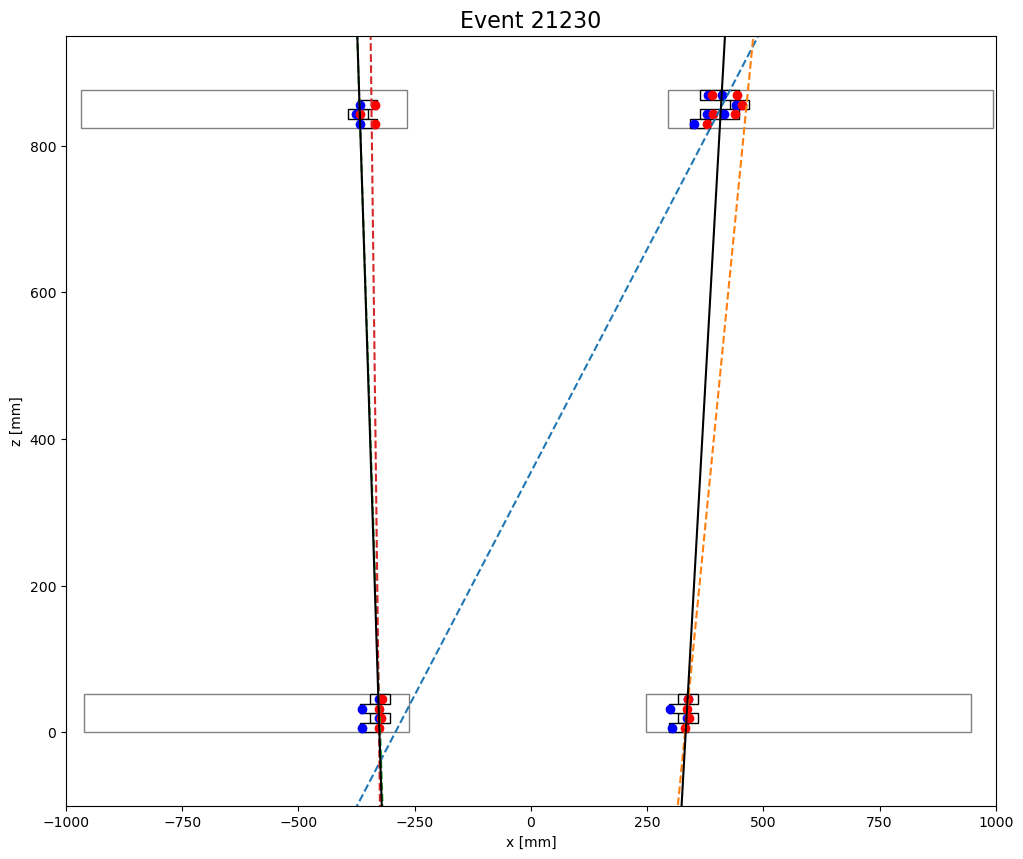

25
22281
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  626.00  634.00   74.0  368.20  360.20  856.0   364.2   
1         0      4  624.20  635.80  108.0  370.00  358.40  830.0   364.2   
2         0      3  635.20  666.80  294.0  359.00  327.40  843.0   343.2   
3         1      2  624.50  635.50  101.0  322.90  311.90   32.5   317.4   
4         1      4  625.60  634.40   82.0  321.80  313.00    6.5   317.4   
5         1      1  596.00  622.00  240.0  351.40  325.40   45.5   338.4   
6         1      3  593.90  624.10  281.0  353.50  323.30   19.5   338.4   
7         2      2   82.54   85.46   27.0 -349.94 -352.86  856.0  -351.4   
8         2      4   72.49   95.51  214.0 -339.89 -362.91  830.0  -351.4   
9         2      1   52.12   73.88  202.0 -319.52 -341.28  869.0  -330.4   
10        2      3   53.42   72.58  178.0 -320.82 -339.98  843.0  -330.4   
11        3      2   41.84   42.16    3.0 -303.34 -303.66   32.5  -303.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


26
22861
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      3  519.400  530.60  105.0  474.800  463.60  843.0  469.2000   
1         0      1  516.800  533.20  153.0  477.400  461.00  869.0  469.2000   
2         0      2  490.200  517.80  256.0  504.000  476.40  856.0  490.2000   
3         0      4  488.600  519.40  286.0  505.600  474.80  830.0  490.2000   
4         1      1  518.800  531.20  115.0  428.600  416.20   45.5  422.4000   
5         1      3  520.600  529.40   82.0  426.800  418.00   19.5  422.4000   
6         1      2  493.400  514.60  196.0  454.000  432.80   32.5  443.4000   
7         1      4  487.200  520.80  311.0  460.200  426.60    6.5  443.4000   
8         2      1  229.600  232.40   26.0 -497.000 -499.80  869.0 -498.4000   
9         2      1   62.570   63.43    8.0 -329.970 -330.83  869.0 -330.4000   
10        2      2   73.700   94.30  191.0 -341.100 -361.70  856.0 -351.4000   
11        2      4  200.100  21

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


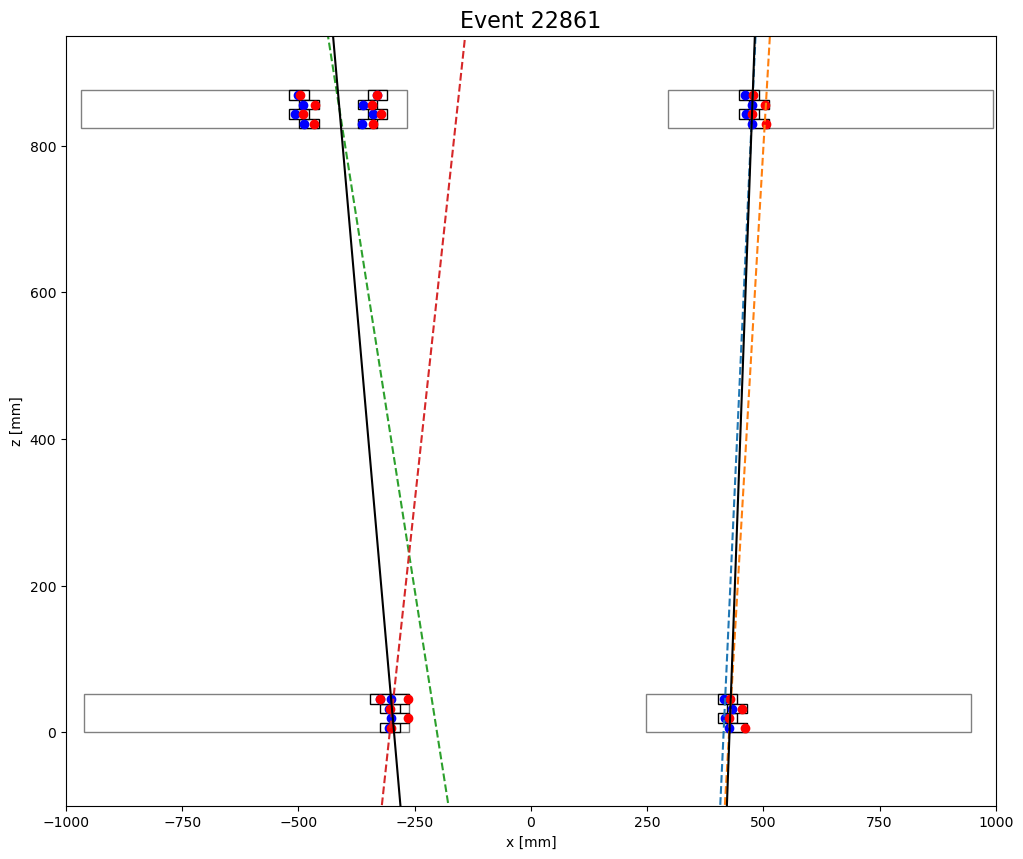

27
23701
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      4  582.80  593.20   97.0  411.40  401.00  830.0  406.200   
1         0      1  553.40  580.60  252.0  440.80  413.60  869.0  427.200   
2         0      3  552.60  581.40  268.0  441.60  412.80  843.0  427.200   
3         1      2  585.90  590.10   40.0  361.50  357.30   32.5  359.400   
4         1      4  581.40  594.60  122.0  366.00  352.80    6.5  359.400   
5         1      1  556.30  577.70  199.0  391.10  369.70   45.5  380.400   
6         1      3  554.20  579.80  237.0  393.20  367.60   19.5  380.400   
7         2      4   74.37   93.63  179.0 -341.77 -361.03  830.0 -351.400   
8         2      3   95.46  114.50  177.0 -362.86 -381.90  843.0 -372.380   
9         2      2   73.03   94.97  204.0 -340.43 -362.37  856.0 -351.400   
10        3      1   62.48   63.52   10.0 -323.98 -325.02   45.5 -324.500   
11        3      3   61.85   64.15   21.0 -323.35 -325.65   19.5 -3

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


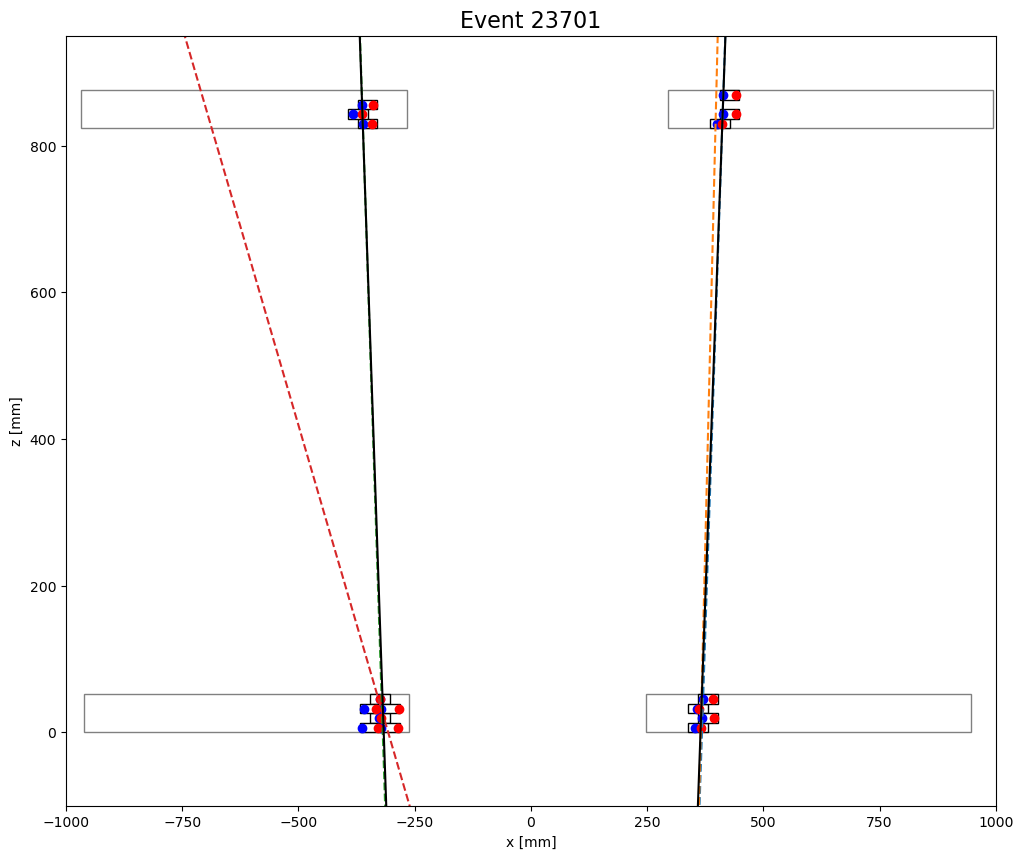

28
24070
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  600.80  617.20  152.0  393.40  377.00  869.0   385.2   
1         0      3  599.20  618.80  182.0  395.00  375.40  843.0   385.2   
2         0      2  619.20  640.80  200.0  375.00  353.40  856.0   364.2   
3         0      4  620.50  639.50  176.0  373.70  354.70  830.0   364.2   
4         1      3  607.80  610.20   22.0  339.60  337.20   19.5   338.4   
5         1      1  606.30  611.70   50.0  341.10  335.70   45.5   338.4   
6         1      2  569.50  606.50  344.0  377.90  340.90   32.5   359.4   
7         1      4  568.70  607.30  359.0  378.70  340.10    6.5   359.4   
8         2      2   78.41   89.59  104.0 -345.81 -356.99  856.0  -351.4   
9         2      3   49.42   76.58  252.0 -316.82 -343.98  843.0  -330.4   
10        2      4   77.33   90.67  124.0 -344.73 -358.07  830.0  -351.4   
11        2      1   48.84   77.16  263.0 -316.24 -344.56  869.0  -330.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


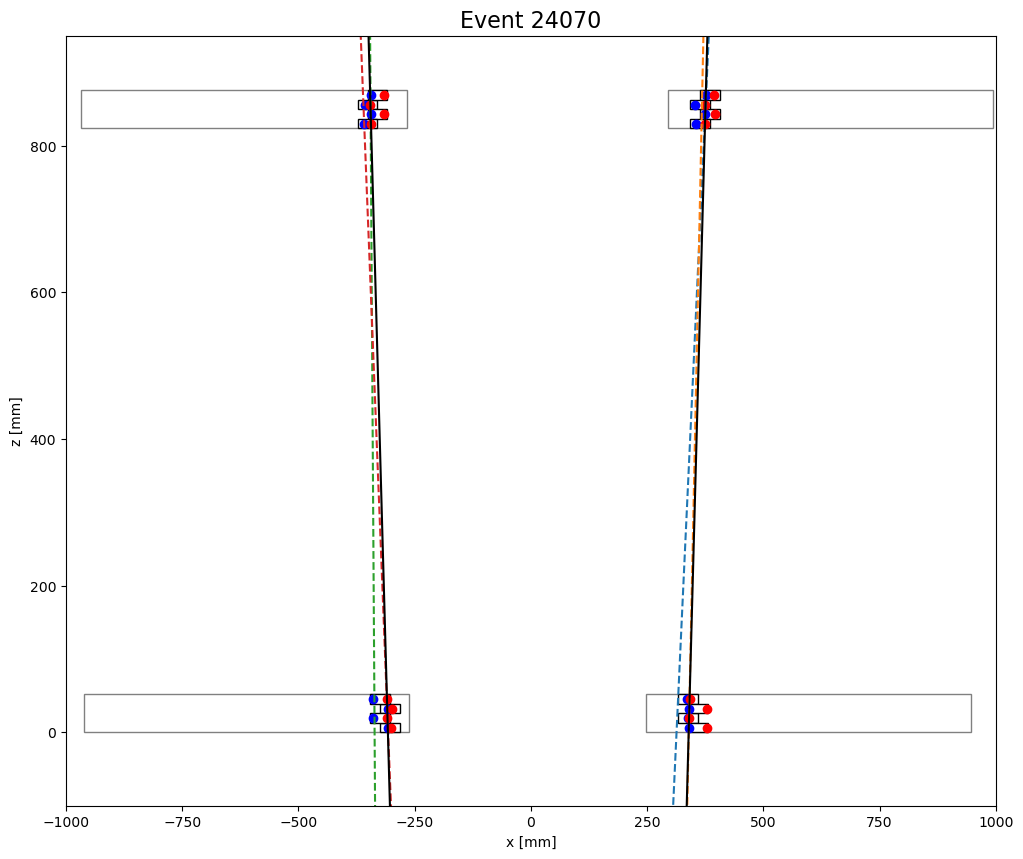

29
25252
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  629.10  630.90   17.0  365.10  363.30  856.0   364.2   
1         0      4  628.80  631.20   23.0  365.40  363.00  830.0   364.2   
2         0      3  631.50  670.50  363.0  362.70  323.70  843.0   343.2   
3         1      2  625.60  634.40   81.0  321.80  313.00   32.5   317.4   
4         1      4  626.70  633.30   61.0  320.70  314.10    6.5   317.4   
5         1      1  594.80  623.20  264.0  352.60  324.20   45.5   338.4   
6         1      3  592.40  625.60  309.0  355.00  321.80   19.5   338.4   
7         2      2   79.93   88.07   76.0 -347.33 -355.47  856.0  -351.4   
8         2      4   78.81   89.19   96.0 -346.21 -356.59  830.0  -351.4   
9         2      1   47.00   79.00  297.0 -314.40 -346.40  869.0  -330.4   
10        2      3   48.26   77.74  274.0 -315.66 -345.14  843.0  -330.4   
11        3      2   39.28   44.72   50.0 -300.78 -306.22   32.5  -303.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


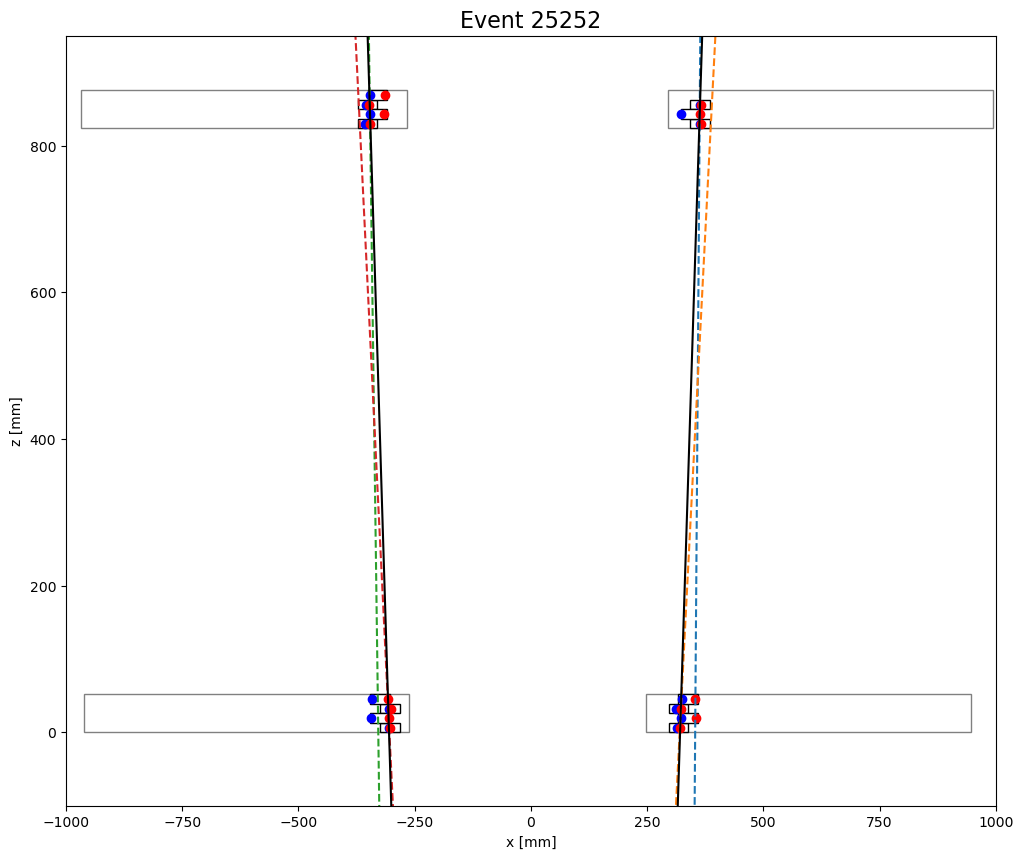

30
26112
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  622.00  638.00  149.0  372.20  356.20  856.0   364.2   
1         0      4  617.60  642.40  230.0  376.60  351.80  830.0   364.2   
2         0      3  639.60  662.40  212.0  354.60  331.80  843.0   343.2   
3         1      2  629.30  630.70   14.0  318.10  316.70   32.5   317.4   
4         1      4  627.80  632.20   41.0  319.60  315.20    6.5   317.4   
5         1      1  591.00  627.00  334.0  356.40  320.40   45.5   338.4   
6         2      3  100.20  109.80   90.0 -367.60 -377.20  843.0  -372.4   
7         2      4   73.11   94.89  202.0 -340.51 -362.29  830.0  -351.4   
8         2      2   72.44   95.56  215.0 -339.84 -362.96  856.0  -351.4   
9         3      1   62.70   63.30    6.0 -324.20 -324.80   45.5  -324.5   
10        3      3   61.49   64.51   28.0 -322.99 -326.01   19.5  -324.5   
11        3      4   26.90   57.10  280.0 -288.40 -318.60    6.5  -303.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


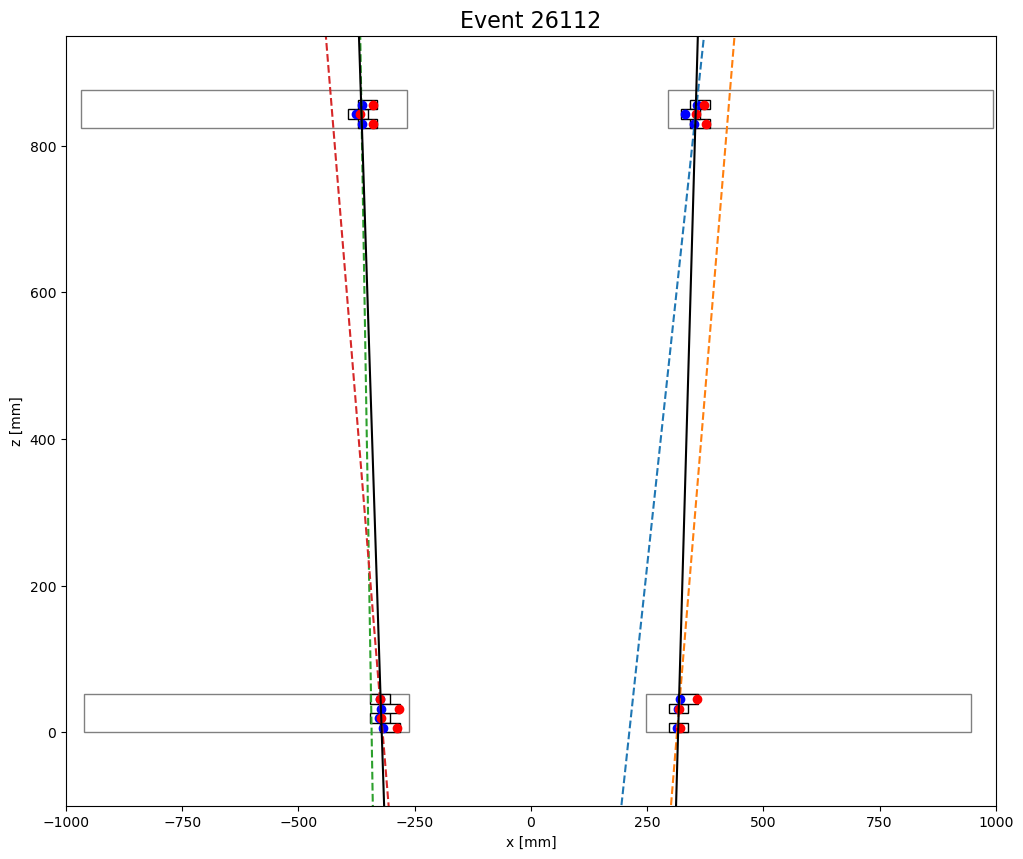

31
26629
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  598.50  619.50  196.0  395.70  374.70  869.0   385.2   
1         0      2  621.00  639.00  166.0  373.20  355.20  856.0   364.2   
2         0      4  621.60  638.40  156.0  372.60  355.80  830.0   364.2   
3         0      3  596.20  621.80  238.0  398.00  372.40  843.0   385.2   
4         1      3  607.90  610.10   20.0  339.50  337.30   19.5   338.4   
5         1      1  608.00  610.00   19.0  339.40  337.40   45.5   338.4   
6         1      2  612.60  647.40  324.0  334.80  300.00   32.5   317.4   
7         1      4  613.50  646.50  307.0  333.90  300.90    6.5   317.4   
8         2      2   83.34   84.66   12.0 -350.74 -352.06  856.0  -351.4   
9         2      4   82.09   85.91   36.0 -349.49 -353.31  830.0  -351.4   
10        2      3   44.49   81.51  344.0 -311.89 -348.91  843.0  -330.4   
11        2      1   43.59   82.41  360.0 -310.99 -349.81  869.0  -330.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


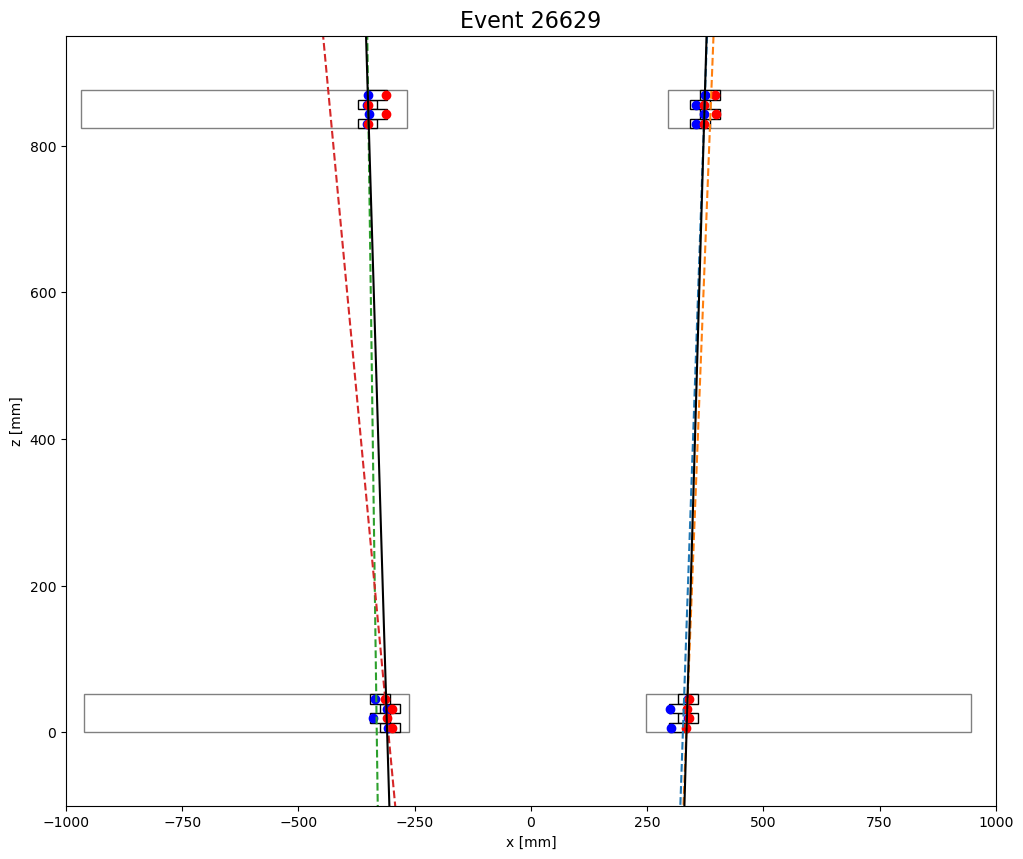

32
28355
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      3  600.80  617.20  153.0  393.40  377.00  843.0  385.20   
1         0      4  618.80  641.20  208.0  375.40  353.00  830.0  364.20   
2         0      1  599.50  618.50  177.0  394.70  375.70  869.0  385.20   
3         0      2  616.60  643.40  249.0  377.60  350.80  856.0  364.20   
4         1      1  608.00  610.00   19.0  339.40  337.40   45.5  338.40   
5         1      2  581.60  594.40  119.0  365.80  353.00   32.5  359.40   
6         1      3  609.00  609.00   -2.0  338.40  338.40   19.5  338.40   
7         1      1  557.10  576.90  185.0  390.30  370.50   45.5  380.40   
8         1      3  591.90  626.10  318.0  355.50  321.30   19.5  338.40   
9         1      4  573.50  602.50  269.0  373.90  344.90    6.5  359.40   
10        1      4  610.60  649.40  360.0  336.80  298.00    6.5  317.40   
11        2      3   99.32  110.70  106.0 -366.72 -378.10  843.0 -372.41   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


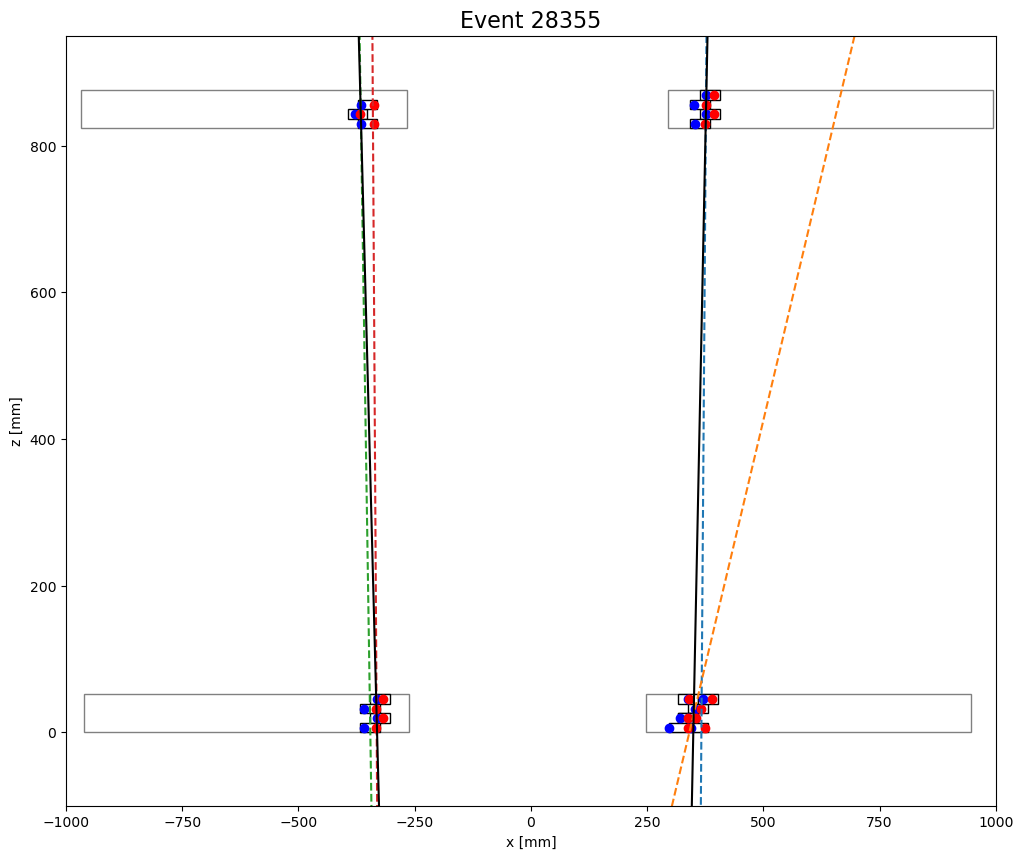

33
28587
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      3  645.600  656.40  100.0  348.600  337.80  843.0  343.2000   
1         0      2  617.500  642.50  231.0  376.700  351.70  856.0  364.2000   
2         0      1  643.900  658.10  132.0  350.300  336.10  869.0  343.2000   
3         0      4  614.600  645.40  286.0  379.600  348.80  830.0  364.2000   
4         1      3  606.200  611.80   52.0  341.200  335.60   19.5  338.4000   
5         1      1  596.100  621.90  239.0  351.300  325.50   45.5  338.4000   
6         1      2  575.800  600.20  226.0  371.600  347.20   32.5  359.4000   
7         1      2  620.700  639.30  173.0  326.700  308.10   32.5  317.4000   
8         1      4  619.200  640.80  200.0  328.200  306.60    6.5  317.4000   
9         1      4  610.800  649.20  357.0  336.600  298.20    6.5  317.4000   
10        2      2   35.600   48.40  119.0 -303.000 -315.80  856.0 -309.4000   
11        2      4   35.060   4

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


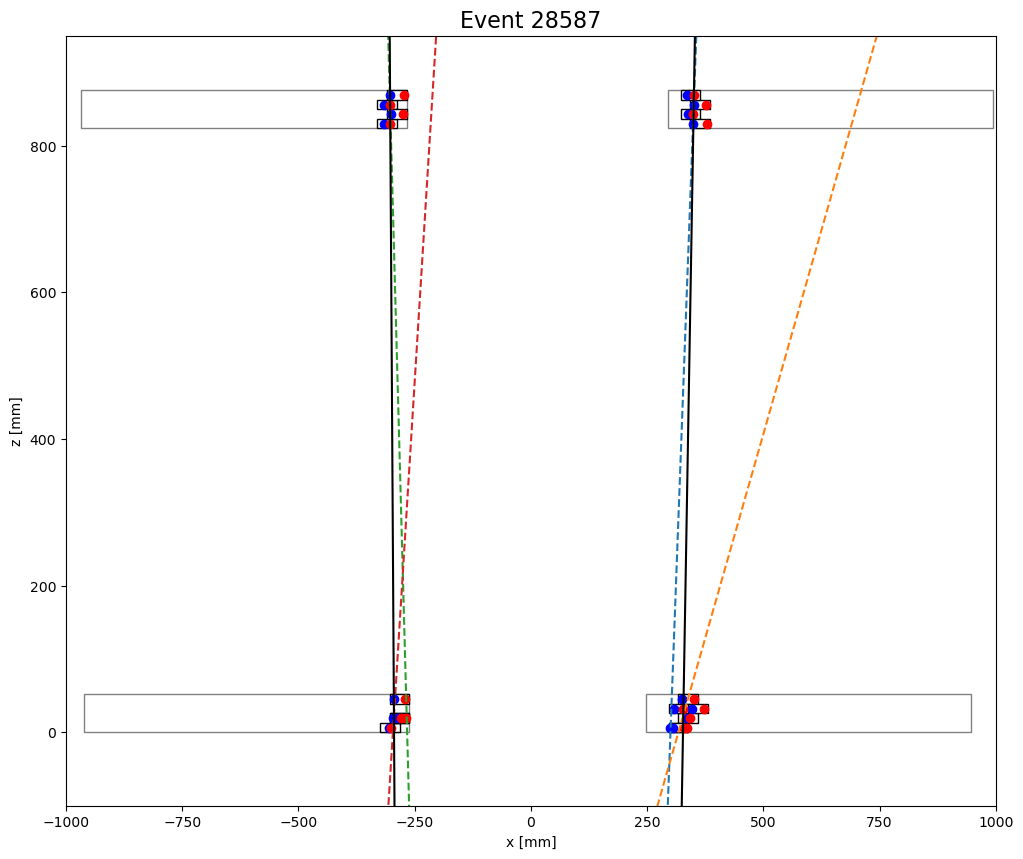

34
32438
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      1  601.30  616.70  142.0  392.90  377.50  869.0  385.200   
1         0      3  602.90  615.10  113.0  391.30  379.10  843.0  385.200   
2         0      4  573.10  602.90  277.0  421.10  391.30  830.0  406.200   
3         0      3  629.80  672.20  393.0  364.40  322.00  843.0  343.200   
4         0      1  626.10  675.90  463.0  368.10  318.30  869.0  343.200   
5         1      2  578.40  597.60  178.0  369.00  349.80   32.5  359.400   
6         1      1  597.10  620.90  221.0  350.30  326.50   45.5  338.400   
7         1      4  577.60  598.40  193.0  369.80  349.00    6.5  359.400   
8         1      3  598.20  619.80  201.0  349.20  327.60   19.5  338.400   
9         2      1   61.18   64.82   34.0 -328.58 -332.22  869.0 -330.400   
10        2      2  293.20  294.80   16.0 -560.60 -562.20  856.0 -561.400   
11        2      3   62.17   63.83   16.0 -329.57 -331.23  843.0 -3

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


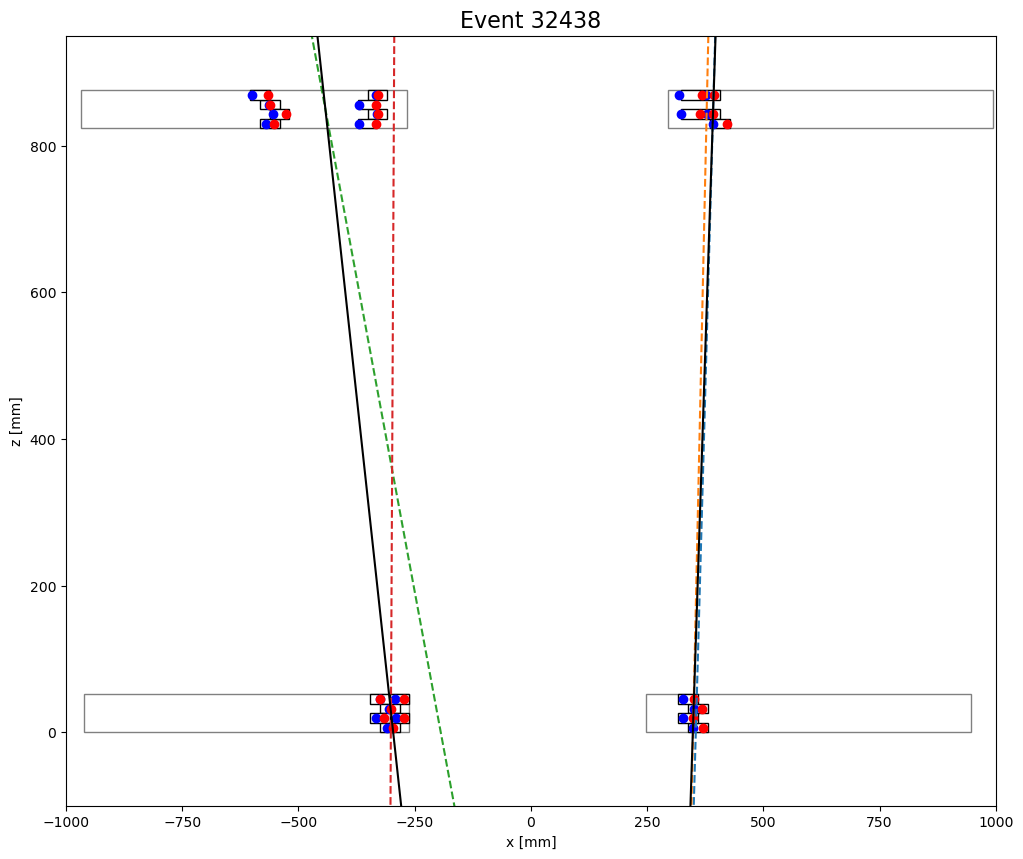

35
34529
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      4  461.700  462.30    6.0  532.500  531.90  830.0  532.2000   
1         0      3  429.300  452.70  217.0  564.900  541.50  843.0  553.2000   
2         0      2  450.400  473.60  216.0  543.800  520.60  856.0  532.2000   
3         1      4  630.000  630.00  -19.0  317.400  317.40    6.5  317.4000   
4         1      1  607.500  610.50   28.0  339.900  336.90   45.5  338.4000   
5         1      2  620.000  640.00  186.0  327.400  307.40   32.5  317.4000   
6         1      3  596.900  621.10  225.0  350.500  326.30   19.5  338.4000   
7         2      3  100.900  109.10   76.0 -368.300 -376.50  843.0 -372.4000   
8         2      4  120.400  131.60  105.0 -387.800 -399.00  830.0 -393.4000   
9         2      3  137.900  156.10  170.0 -405.300 -423.50  843.0 -414.4000   
10        2      2   75.090   92.91  166.0 -342.490 -360.31  856.0 -351.4000   
11        2      4   73.560   9

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


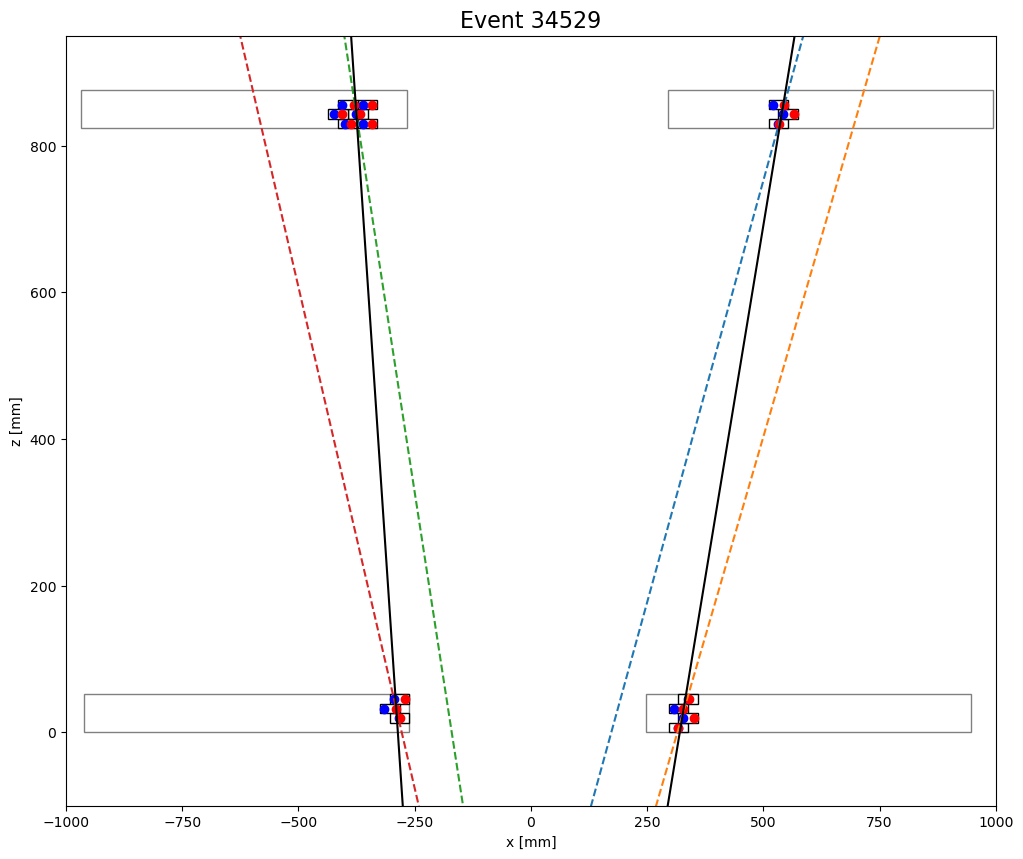

36
35576
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  606.10  611.90   55.0  388.10  382.30  869.0   385.2   
1         0      3  605.00  613.00   74.0  389.20  381.20  843.0   385.2   
2         0      2  614.30  645.70  292.0  379.90  348.50  856.0   364.2   
3         0      4  614.70  645.30  285.0  379.50  348.90  830.0   364.2   
4         1      1  608.70  609.30    6.0  338.70  338.10   45.5   338.4   
5         1      3  609.00  609.00   -4.0  338.40  338.40   19.5   338.4   
6         1      4  611.80  648.20  339.0  335.60  299.20    6.5   317.4   
7         2      2   76.53   91.47  139.0 -343.93 -358.87  856.0  -351.4   
8         2      4   77.29   90.71  125.0 -344.69 -358.11  830.0  -351.4   
9         2      3   92.90  117.10  225.0 -360.30 -384.50  843.0  -372.4   
10        3      1   62.66   63.34    6.0 -324.16 -324.84   45.5  -324.5   
11        3      3   61.76   64.24   23.0 -323.26 -325.74   19.5  -324.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


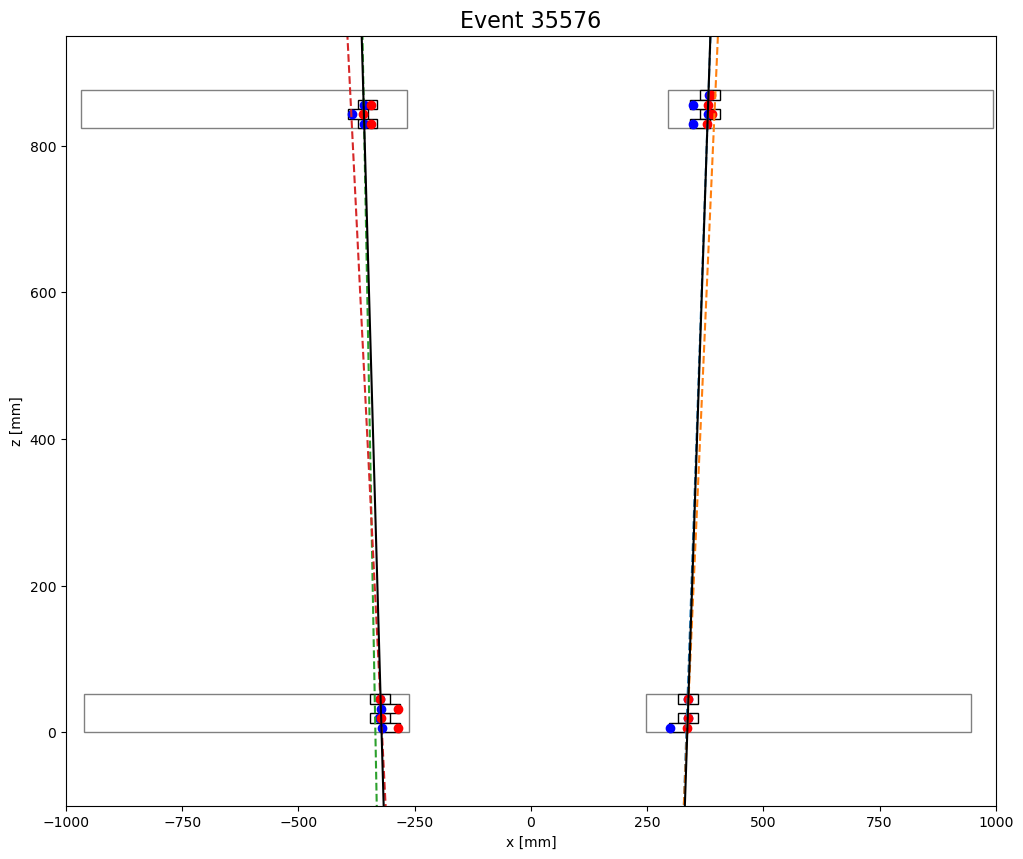

37
38174
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  604.50  613.50   83.0  389.70  380.70  869.0   385.2   
1         0      3  603.10  614.90  110.0  391.10  379.30  843.0   385.2   
2         0      4  573.10  602.90  277.0  421.10  391.30  830.0   406.2   
3         1      2  579.00  597.00  167.0  368.40  350.40   32.5   359.4   
4         1      1  597.00  621.00  222.0  350.40  326.40   45.5   338.4   
5         1      4  577.50  598.50  195.0  369.90  348.90    6.5   359.4   
6         1      3  597.80  620.20  208.0  349.60  327.20   19.5   338.4   
7         2      4   82.76   85.24   23.0 -350.16 -352.64  830.0  -351.4   
8         2      2   77.92   90.08  113.0 -345.32 -357.48  856.0  -351.4   
9         2      1   48.21   77.79  275.0 -315.61 -345.19  869.0  -330.4   
10        2      3   49.78   76.22  246.0 -317.18 -343.62  843.0  -330.4   
11        3      4   39.01   44.99   56.0 -300.51 -306.49    6.5  -303.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


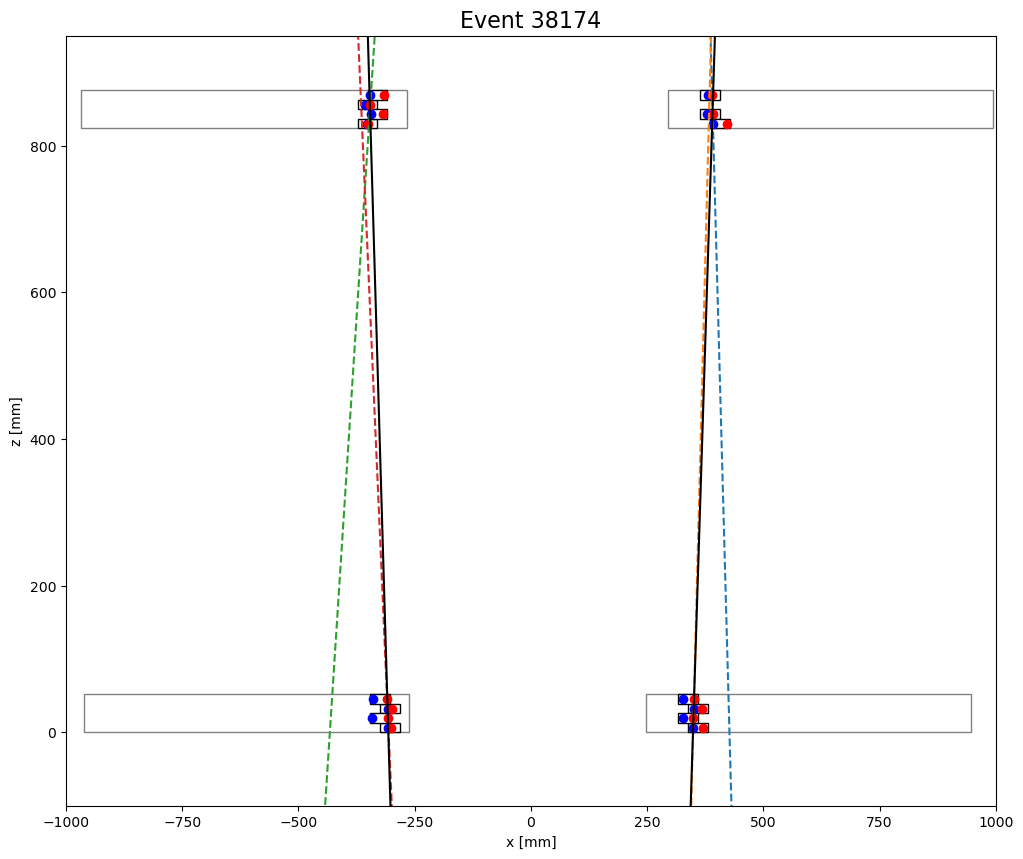

38
39825
    chamber  layer    xleft  xright   time      xrg     xlg     zg   center  \
0         0      1  605.300  612.70   68.0  388.900  381.50  869.0  385.200   
1         0      3  603.700  614.30   98.0  390.500  379.90  843.0  385.200   
2         0      4  615.500  644.50  270.0  378.700  349.70  830.0  364.200   
3         1      1  603.400  614.60  105.0  344.000  332.80   45.5  338.400   
4         1      3  604.800  613.20   78.0  342.600  334.20   19.5  338.400   
5         1      2  573.000  603.00  279.0  374.400  344.40   32.5  359.400   
6         1      4  571.800  604.20  301.0  375.600  343.20    6.5  359.400   
7         2      3   52.070   73.93  203.0 -319.470 -341.33  843.0 -330.400   
8         2      2   75.980   92.02  149.0 -343.380 -359.42  856.0 -351.400   
9         2      1   50.900   75.10  225.0 -318.300 -342.50  869.0 -330.400   
10        2      3  464.100  501.90  351.0 -731.500 -769.30  843.0 -750.400   
11        2      4   74.910   93.09  169.0 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


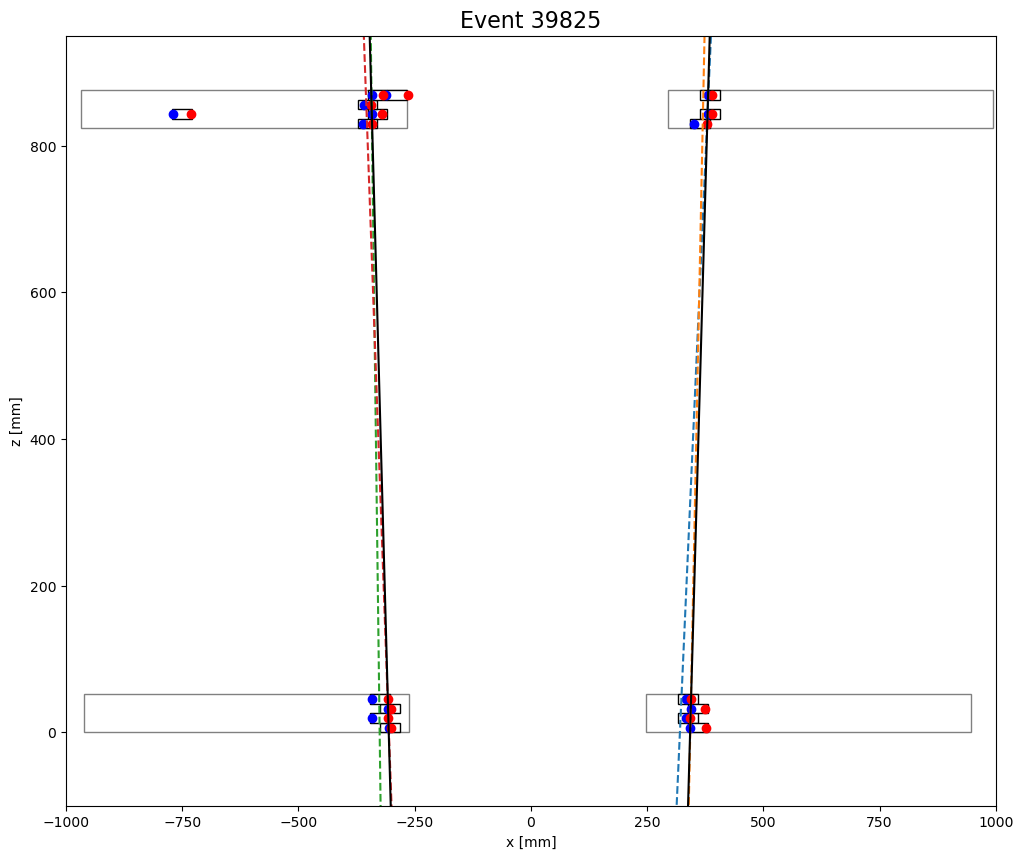

39
39956
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  608.40  609.60   11.0  385.80  384.60  869.0  385.20   
1         0      3  607.70  610.30   25.0  386.50  383.90  843.0  385.20   
2         0      4  611.00  649.00  352.0  383.20  345.20  830.0  364.20   
3         1      3  602.50  615.50  120.0  344.90  331.90   19.5  338.40   
4         1      2  575.70  600.30  228.0  371.70  347.10   32.5  359.40   
5         1      4  573.90  602.10  261.0  373.50  345.30    6.5  359.40   
6         2      4   36.32   47.68  106.0 -303.72 -315.08  830.0 -309.40   
7         2      3   48.70   77.30  266.0 -316.10 -344.70  843.0 -330.40   
8         2      4  621.40  638.60  160.0 -888.80 -906.00  830.0 -897.40   
9         2      1  643.80  658.20  133.0 -911.20 -925.60  869.0 -918.40   
10        2      3  646.90  655.10   76.0 -914.30 -922.50  843.0 -918.40   
11        2      2  653.60  690.40  342.0 -921.00 -957.80  856.0 -939.40   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


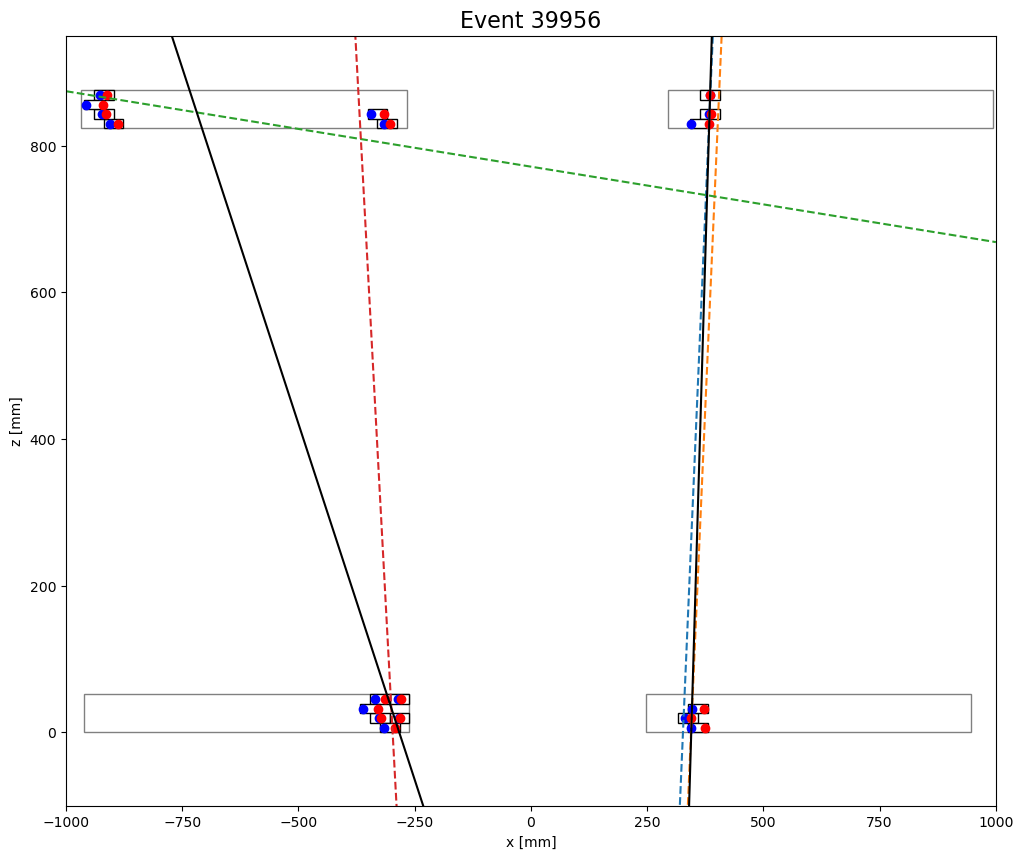

40
40021
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      4  623.90  636.10  114.0  370.30  358.10  830.0   364.2   
1         0      1  597.40  620.60  216.0  396.80  373.60  869.0   385.2   
2         0      3  596.10  621.90  239.0  398.10  372.30  843.0   385.2   
3         1      4  620.60  639.40  174.0  326.80  308.00    6.5   317.4   
4         1      1  601.30  616.70  144.0  346.10  330.70   45.5   338.4   
5         1      3  599.40  618.60  178.0  348.00  328.80   19.5   338.4   
6         1      2  618.20  641.80  220.0  329.20  305.60   32.5   317.4   
7         2      4  118.00  134.00  148.0 -385.40 -401.40  830.0  -393.4   
8         2      3   51.40   74.60  216.0 -318.80 -342.00  843.0  -330.4   
9         2      2   76.84   91.16  133.0 -344.24 -358.56  856.0  -351.4   
10        2      4   75.58   92.42  156.0 -342.98 -359.82  830.0  -351.4   
11        2      3   92.90  117.10  225.0 -360.30 -384.50  843.0  -372.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


chamber: 1
chamber: 2
chamber: 3


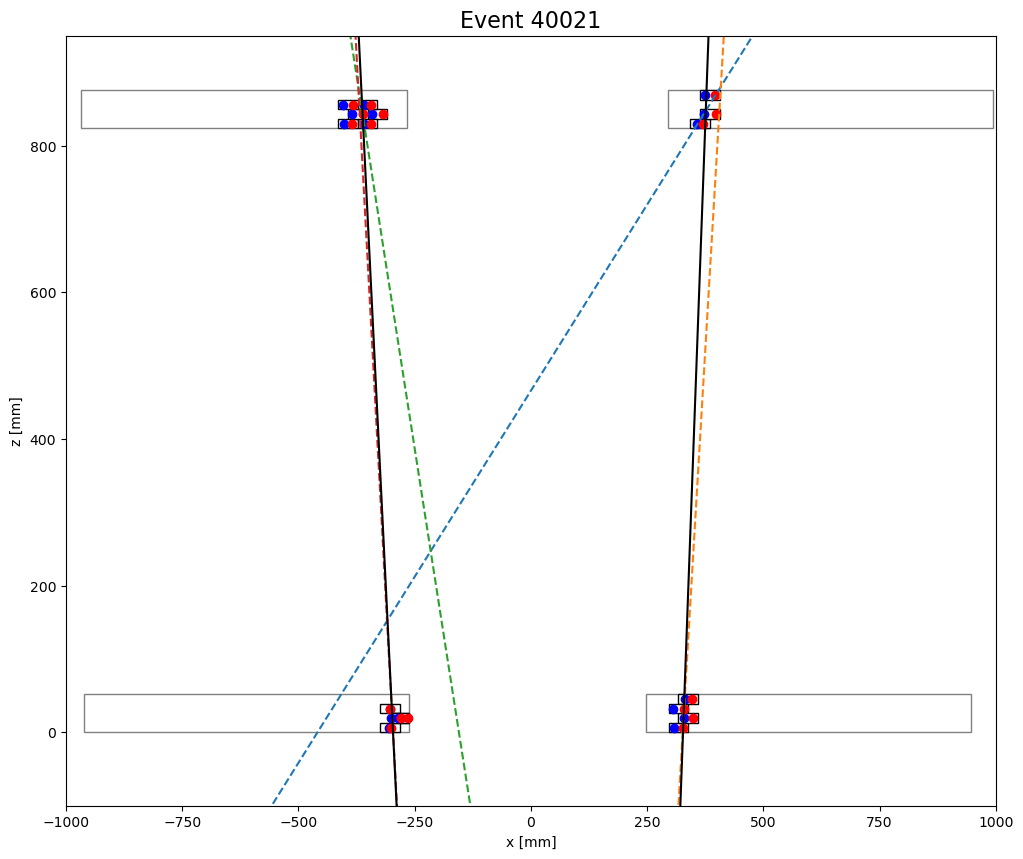

41
40046
    chamber  layer   xleft  xright   time     xrg     xlg     zg   center  \
0         0      4  625.60  634.40   81.0  368.60  359.80  830.0  364.200   
1         0      2  624.10  635.90  109.0  370.10  358.30  856.0  364.200   
2         0      1  595.30  622.70  254.0  398.90  371.50  869.0  385.200   
3         0      3  594.60  623.40  267.0  399.60  370.80  843.0  385.200   
4         1      1  605.90  612.10   57.0  341.50  335.30   45.5  338.400   
5         1      3  604.00  614.00   93.0  343.40  333.40   19.5  338.400   
6         1      4  615.30  644.70  274.0  332.10  302.70    6.5  317.400   
7         2      3  103.80  106.20   22.0 -371.20 -373.60  843.0 -372.400   
8         2      2   65.13  102.90  350.0 -332.53 -370.30  856.0 -351.415   
9         2      4   65.35  102.70  346.0 -332.75 -370.10  830.0 -351.425   
10        3      2   77.82   90.18  115.0 -339.32 -351.68   32.5 -345.500   
11        3      4   76.88   91.12  132.0 -338.38 -352.62    6.5 -3

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


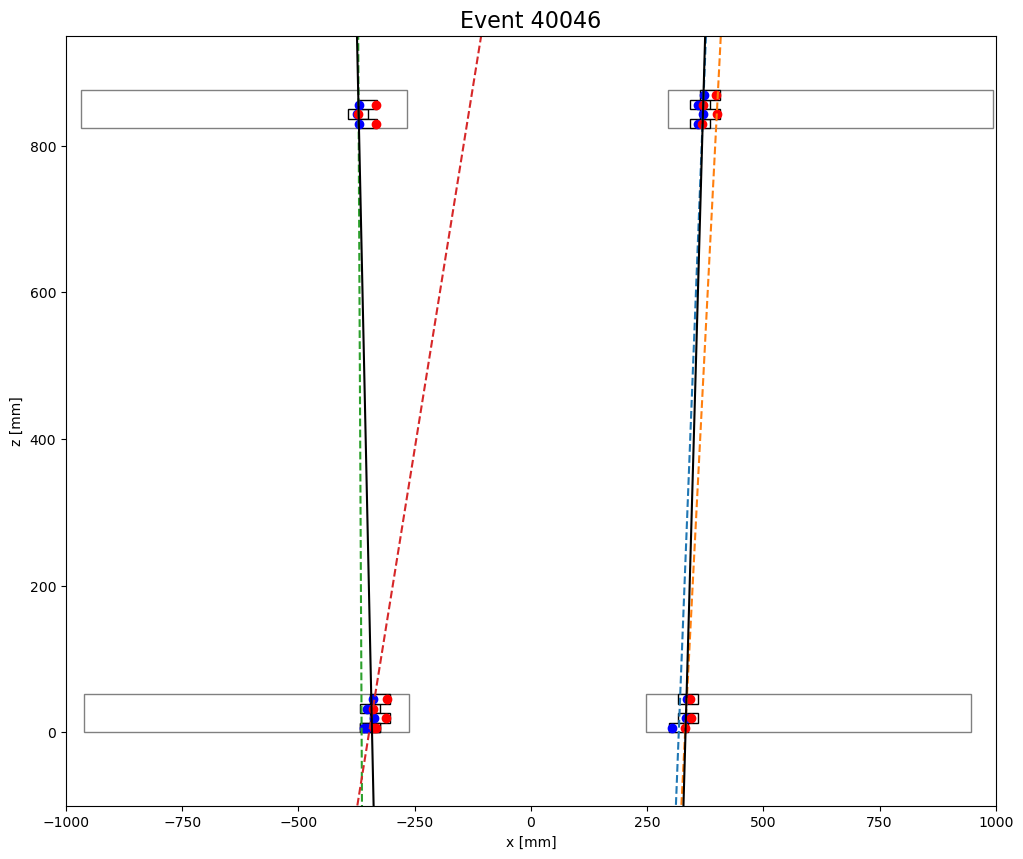

42
40407
    chamber  layer   xleft  xright   time     xrg    xlg     zg  center  \
0         0      3  605.80   612.2   60.0  388.40  382.0  843.0  385.20   
1         0      1  602.20   615.8  126.0  392.00  378.4  869.0  385.20   
2         0      4  572.20   603.8  294.0  422.00  390.4  830.0  406.20   
3         1      2  587.10   588.9   16.0  360.30  358.5   32.5  359.40   
4         1      1  599.80   618.2  171.0  347.60  329.2   45.5  338.40   
5         1      4  586.30   589.7   32.0  361.10  357.7    6.5  359.40   
6         1      3  590.20   627.8  350.0  357.20  319.6   19.5  338.40   
7         2      2  124.40   127.6   29.0 -391.80 -395.0  856.0 -393.40   
8         2      4  123.60   128.4   45.0 -391.00 -395.8  830.0 -393.40   
9         2      3   87.16   122.8  331.0 -354.56 -390.2  843.0 -372.38   
10        3      2   76.30    91.7  143.0 -337.80 -353.2   32.5 -345.50   
11        3      1   93.62   116.4  211.0 -355.12 -377.9   45.5 -366.51   
12        3     

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


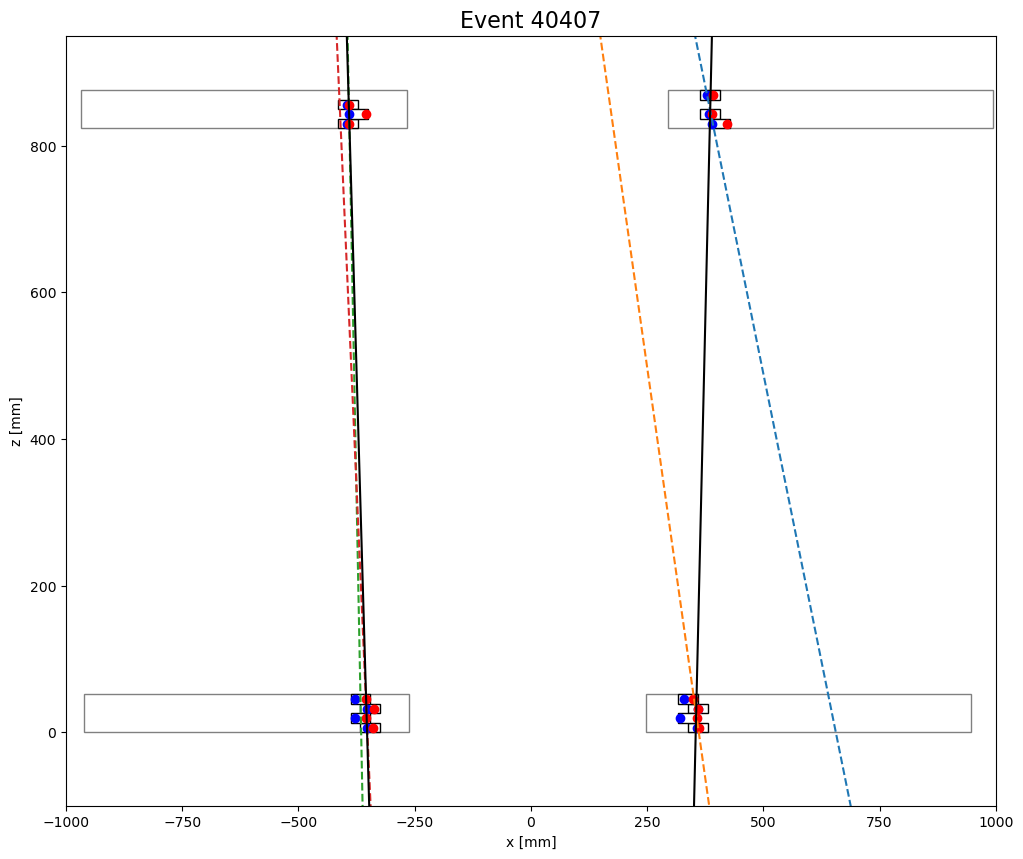

43
40686
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      2  629.100  630.90   17.0  365.100  363.30  856.0  364.2000   
1         0      4  629.800  630.20    3.0  364.400  364.00  830.0  364.2000   
2         0      1  593.100  624.90  296.0  401.100  369.30  869.0  385.2000   
3         1      4  622.000  638.00  148.0  325.400  309.40    6.5  317.4000   
4         1      1  600.200  617.80  164.0  347.200  329.60   45.5  338.4000   
5         1      3  597.800  620.20  207.0  349.600  327.20   19.5  338.4000   
6         1      2  620.600  639.40  175.0  326.800  308.00   32.5  317.4000   
7         2      1   60.640   65.36   44.0 -328.040 -332.76  869.0 -330.4000   
8         2      3   61.220   64.78   33.0 -328.620 -332.18  843.0 -330.4000   
9         2      2   66.740  101.30  320.0 -334.140 -368.70  856.0 -351.4200   
10        2      1   52.610   73.39  193.0 -320.010 -340.79  869.0 -330.4000   
11        2      4   65.530  10

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


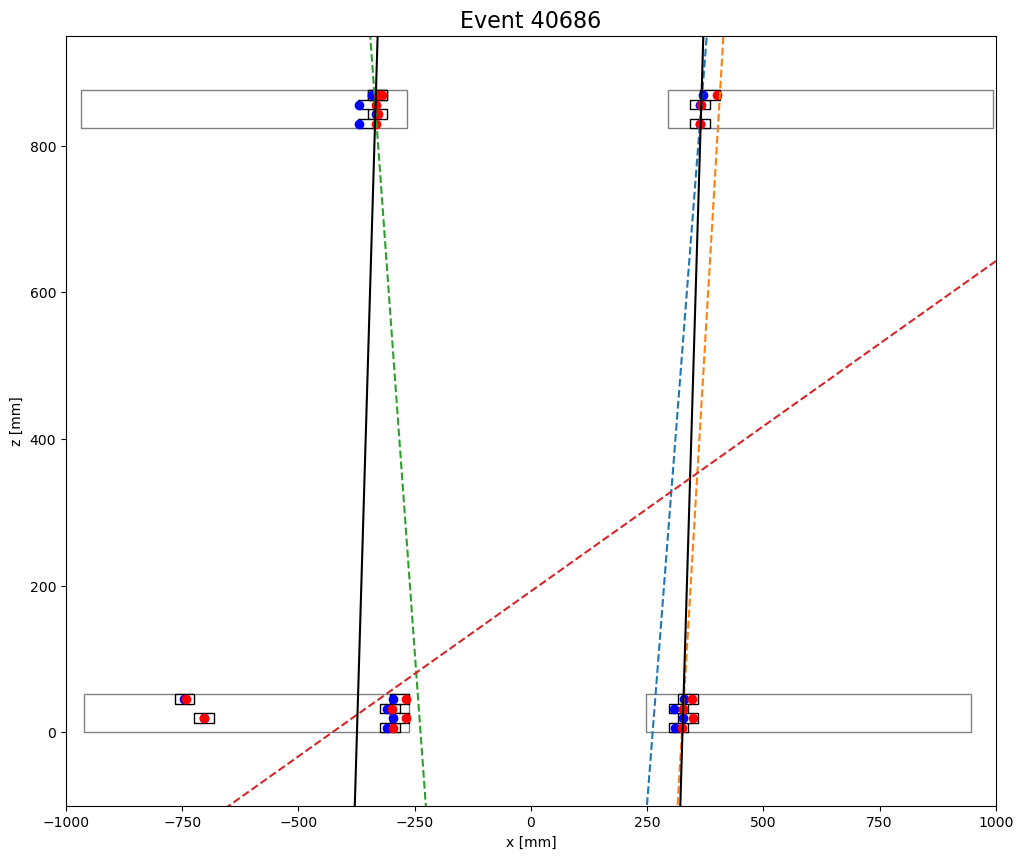

44
45686
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  603.60  614.40  100.0  390.60  379.80  869.0   385.2   
1         0      3  601.40  616.60  141.0  392.80  377.60  843.0   385.2   
2         0      2  616.20  643.80  256.0  378.00  350.40  856.0   364.2   
3         0      4  618.30  641.70  217.0  375.90  352.50  830.0   364.2   
4         1      1  604.40  613.60   86.0  343.00  333.80   45.5   338.4   
5         1      3  602.50  615.50  120.0  344.90  331.90   19.5   338.4   
6         1      2  615.90  644.10  261.0  331.50  303.30   32.5   317.4   
7         1      4  618.20  641.80  219.0  329.20  305.60    6.5   317.4   
8         2      3  101.50  108.50   66.0 -368.90 -375.90  843.0  -372.4   
9         2      2  110.80  141.20  282.0 -378.20 -408.60  856.0  -393.4   
10        2      4  109.90  142.10  300.0 -377.30 -409.50  830.0  -393.4   
11        3      1   58.31   67.69   87.0 -319.81 -329.19   45.5  -324.5   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


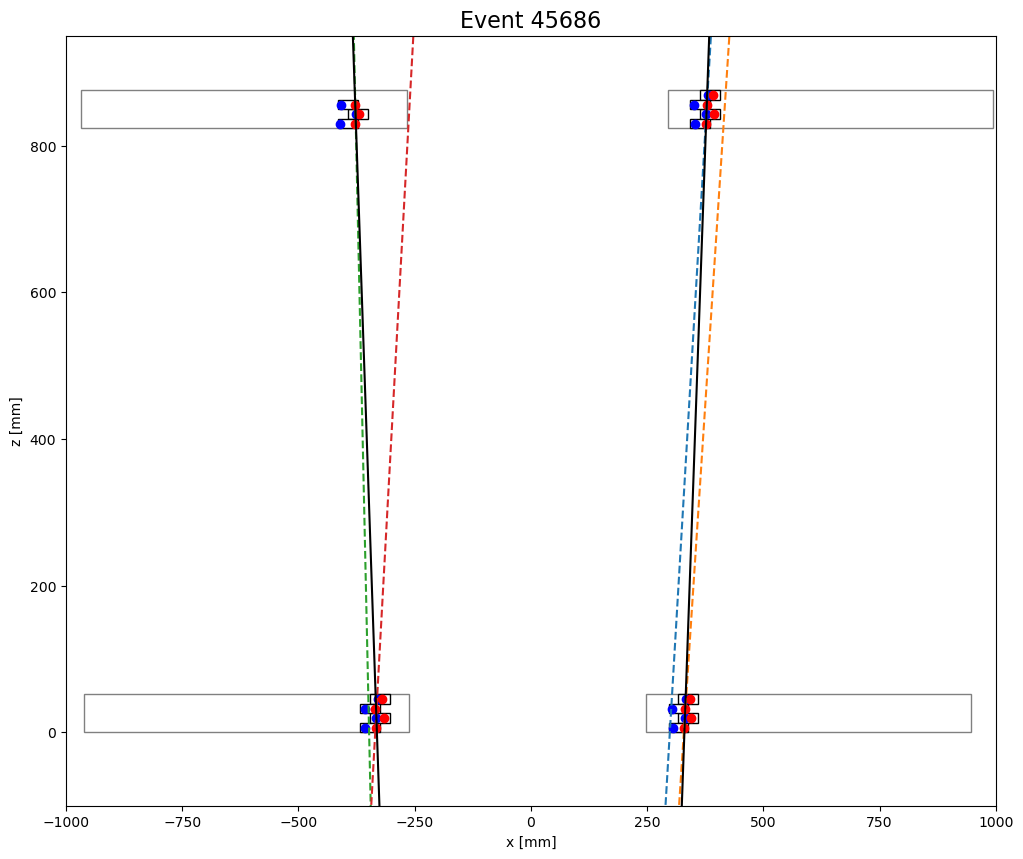

45
47200
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      2  628.00  632.00   37.0  366.20  362.20  856.0   364.2   
1         0      4  626.90  633.10   57.0  367.30  361.10  830.0   364.2   
2         0      3  511.40  538.60  253.0  482.80  455.60  843.0   469.2   
3         0      3  633.30  668.70  329.0  360.90  325.50  843.0   343.2   
4         0      1  504.60  545.40  378.0  489.60  448.80  869.0   469.2   
5         0      1  632.10  669.90  351.0  362.10  324.30  869.0   343.2   
6         0      2  477.80  530.20  486.0  516.40  464.00  856.0   490.2   
7         1      2  628.50  631.50   27.0  318.90  315.90   32.5   317.4   
8         1      4  629.50  630.50    9.0  317.90  316.90    6.5   317.4   
9         1      3  590.50  627.50  343.0  356.90  319.90   19.5   338.4   
10        1      1  591.10  626.90  332.0  356.30  320.50   45.5   338.4   
11        2      2   80.70   87.30   61.0 -348.10 -354.70  856.0  -351.4   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


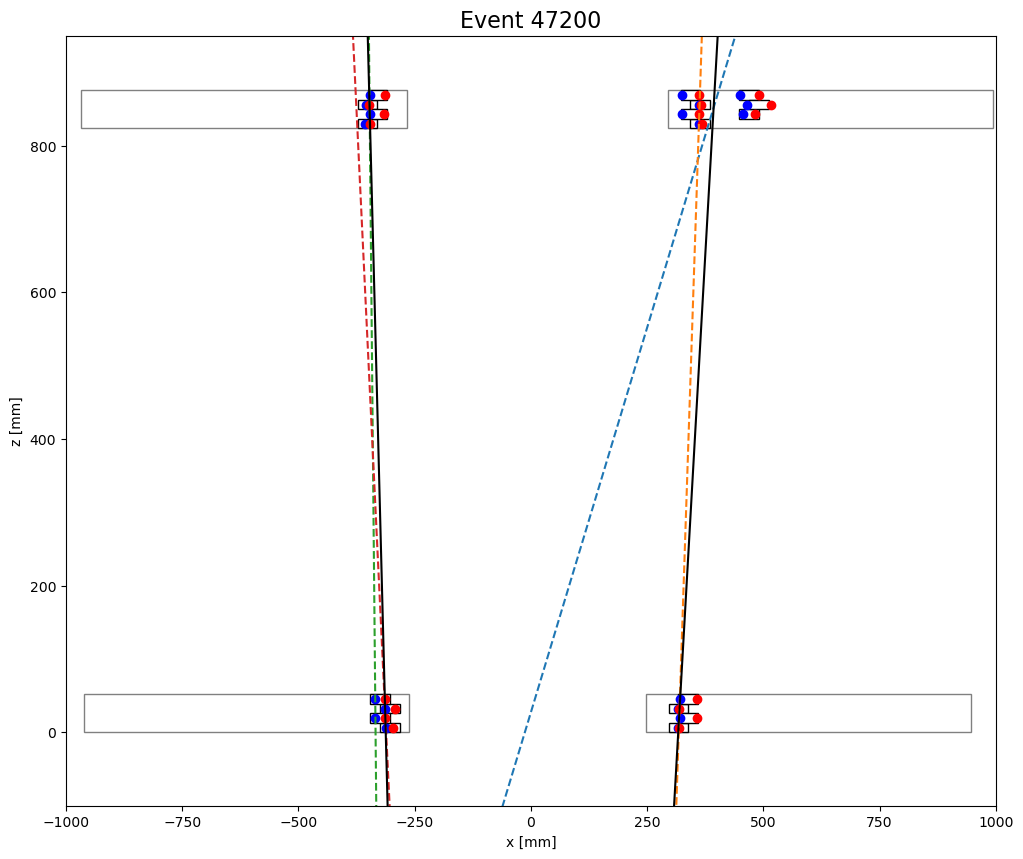

46
49184
    chamber  layer    xleft  xright   time      xrg     xlg     zg    center  \
0         0      1  480.700  485.30   43.0  513.500  508.90  869.0  511.2000   
1         0      1  563.500  570.50   66.0  430.700  423.70  869.0  427.2000   
2         0      3  479.700  486.30   61.0  514.500  507.90  843.0  511.2000   
3         0      3  561.700  572.30   99.0  432.500  421.90  843.0  427.2000   
4         0      4  573.700  602.30  266.0  420.500  391.90  830.0  406.2000   
5         0      4  489.600  518.40  268.0  504.600  475.80  830.0  490.2000   
6         1      1  565.800  568.20   23.0  381.600  379.20   45.5  380.4000   
7         1      3  565.100  568.90   36.0  382.300  378.50   19.5  380.4000   
8         1      2  573.600  602.40  268.0  373.800  345.00   32.5  359.4000   
9         1      4  575.000  601.00  241.0  372.400  346.40    6.5  359.4000   
10        2      1   61.270   64.73   32.0 -328.670 -332.13  869.0 -330.4000   
11        2      3   61.040   6

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


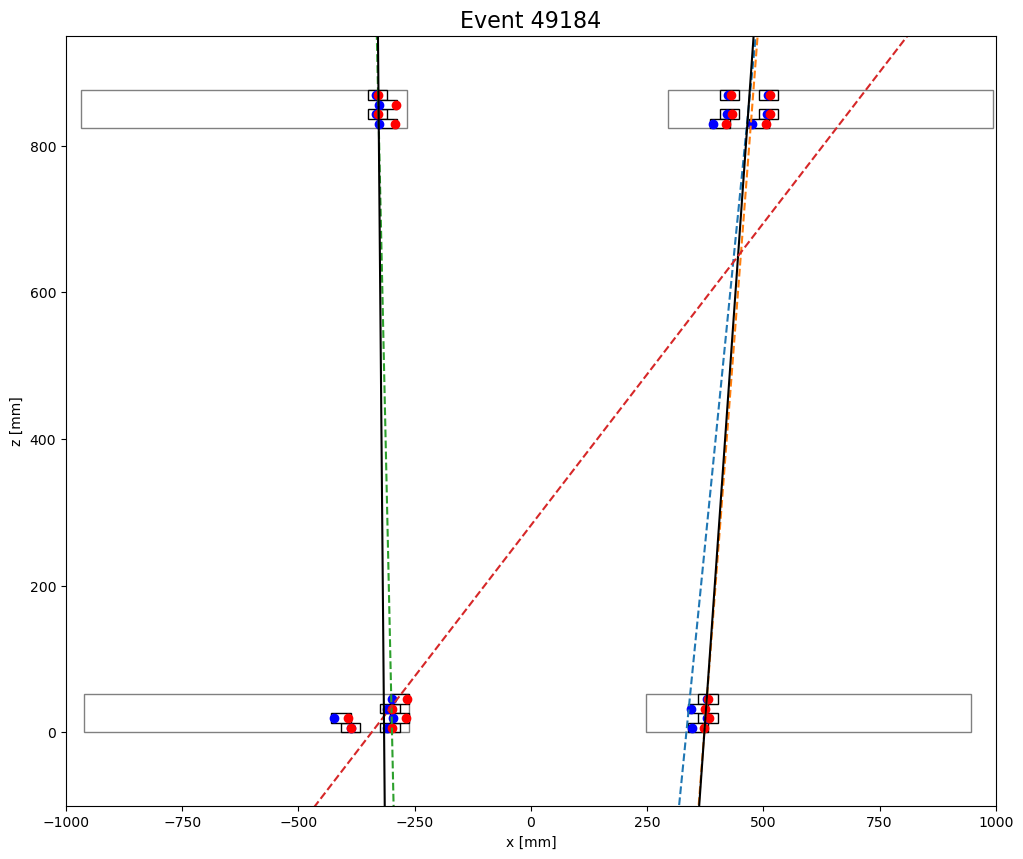

47
49274
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      1  602.20  615.80  126.0  392.00  378.40  869.0  385.20   
1         0      3  600.70  617.30  154.0  393.50  376.90  843.0  385.20   
2         0      2  618.80  641.20  209.0  375.40  353.00  856.0  364.20   
3         1      1  608.10  609.90   16.0  339.30  337.50   45.5  338.40   
4         1      3  607.90  610.10   20.0  339.50  337.30   19.5  338.40   
5         1      4  610.80  649.20  356.0  336.60  298.20    6.5  317.40   
6         2      3   98.96  111.00  112.0 -366.36 -378.40  843.0 -372.38   
7         2      2   69.79   98.21  264.0 -337.19 -365.61  856.0 -351.40   
8         2      4   71.09   96.91  240.0 -338.49 -364.31  830.0 -351.40   
9         3      1   61.40   64.60   30.0 -322.90 -326.10   45.5 -324.50   
10        3      3   60.55   65.45   46.0 -322.05 -326.95   19.5 -324.50   
11        3      2   22.36   61.64  365.0 -283.86 -323.14   32.5 -303.50   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


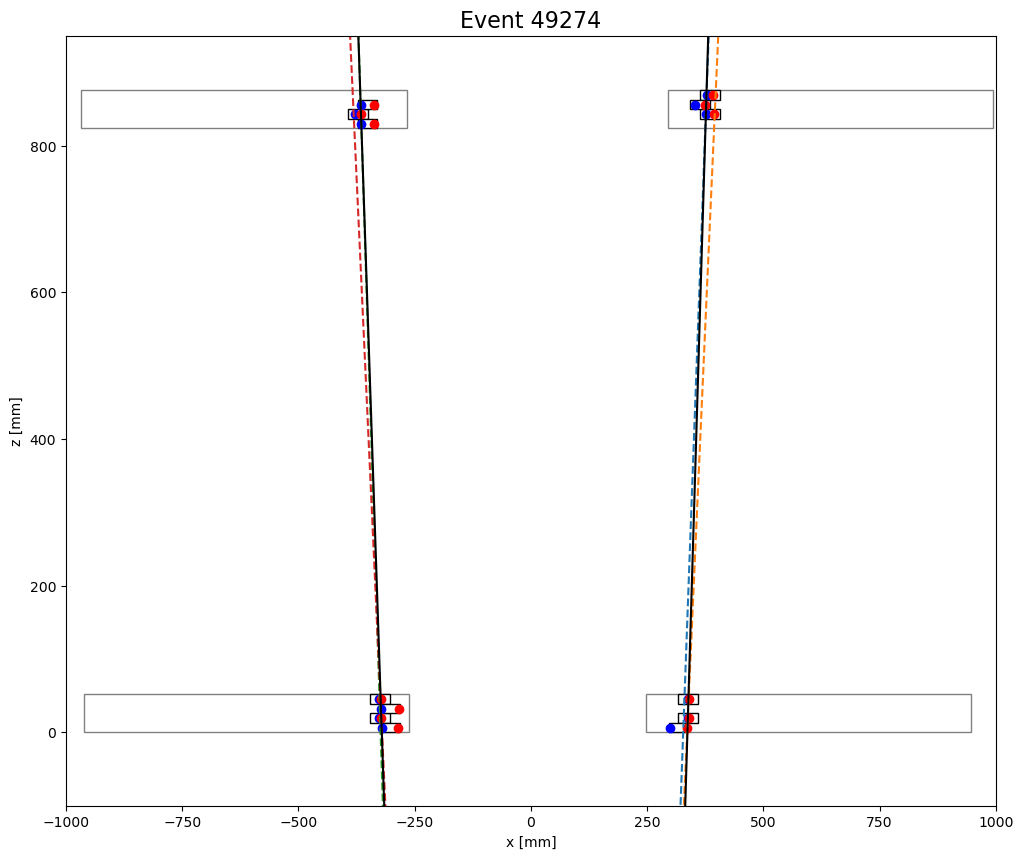

48
49846
    chamber  layer   xleft  xright   time     xrg     xlg     zg  center  \
0         0      4  577.50  598.50  195.0  416.70  395.70  830.0  406.20   
1         0      3  597.90  620.10  206.0  396.30  374.10  843.0  385.20   
2         0      1  596.10  621.90  239.0  398.10  372.30  869.0  385.20   
3         1      3  601.30  616.70  143.0  346.10  330.70   19.5  338.40   
4         1      2  576.60  599.40  212.0  370.80  348.00   32.5  359.40   
5         1      1  599.10  618.90  183.0  348.30  328.50   45.5  338.40   
6         1      4  574.20  601.80  256.0  373.20  345.60    6.5  359.40   
7         2      2   80.52   87.48   65.0 -347.92 -354.88  856.0 -351.40   
8         2      4   81.50   86.50   46.0 -348.90 -353.90  830.0 -351.40   
9         2      3   87.88  122.10  318.0 -355.28 -389.50  843.0 -372.39   
10        3      2   37.17   46.83   90.0 -298.67 -308.33   32.5 -303.50   
11        3      4   36.95   47.05   94.0 -298.45 -308.55    6.5 -303.50   
12 

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


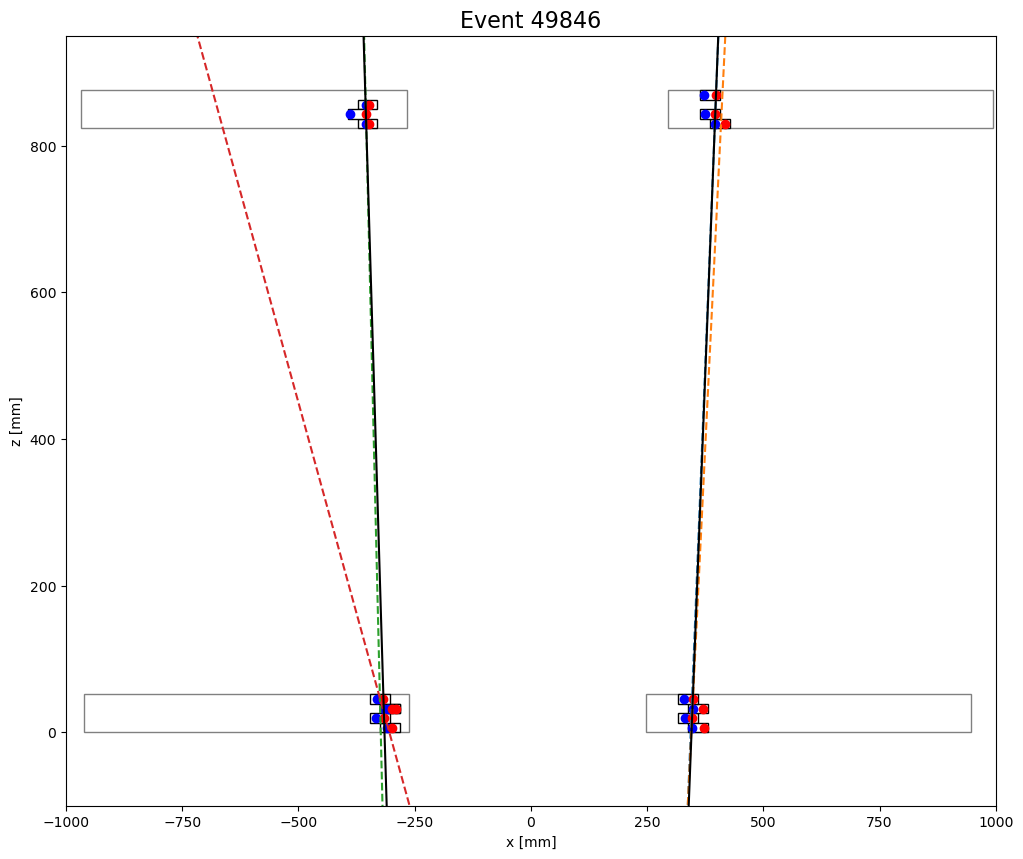

49
50094
    chamber  layer  xleft  xright   time    xrg    xlg     zg  center  \
0         0      2  626.9   633.1   57.0  367.3  361.1  856.0   364.2   
1         0      4  627.8   632.2   41.0  366.4  362.0  830.0   364.2   
2         0      1  592.6   625.4  305.0  401.6  368.8  869.0   385.2   
3         0      3  591.2   626.8  331.0  403.0  367.4  843.0   385.2   
4         1      1  601.3   616.7  144.0  346.1  330.7   45.5   338.4   
5         1      3  599.5   618.5  176.0  347.9  328.9   19.5   338.4   
6         1      2  619.7   640.3  191.0  327.7  307.1   32.5   317.4   
7         1      4  620.0   640.0  186.0  327.4  307.4    6.5   317.4   
8         2      2  166.3   169.7   32.0 -433.7 -437.1  856.0  -435.4   
9         2      4  165.2   170.8   51.0 -432.6 -438.2  830.0  -435.4   
10        2      1  127.9   166.1  355.0 -395.3 -433.5  869.0  -414.4   
11        2      3  129.6   164.4  323.0 -397.0 -431.8  843.0  -414.4   
12        3      2  126.0   126.0   -3.0 -

/tmp/ipykernel_88138/3241603464.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_subevent=event[event['chamber']==chamber][event['valid_hit']==True]


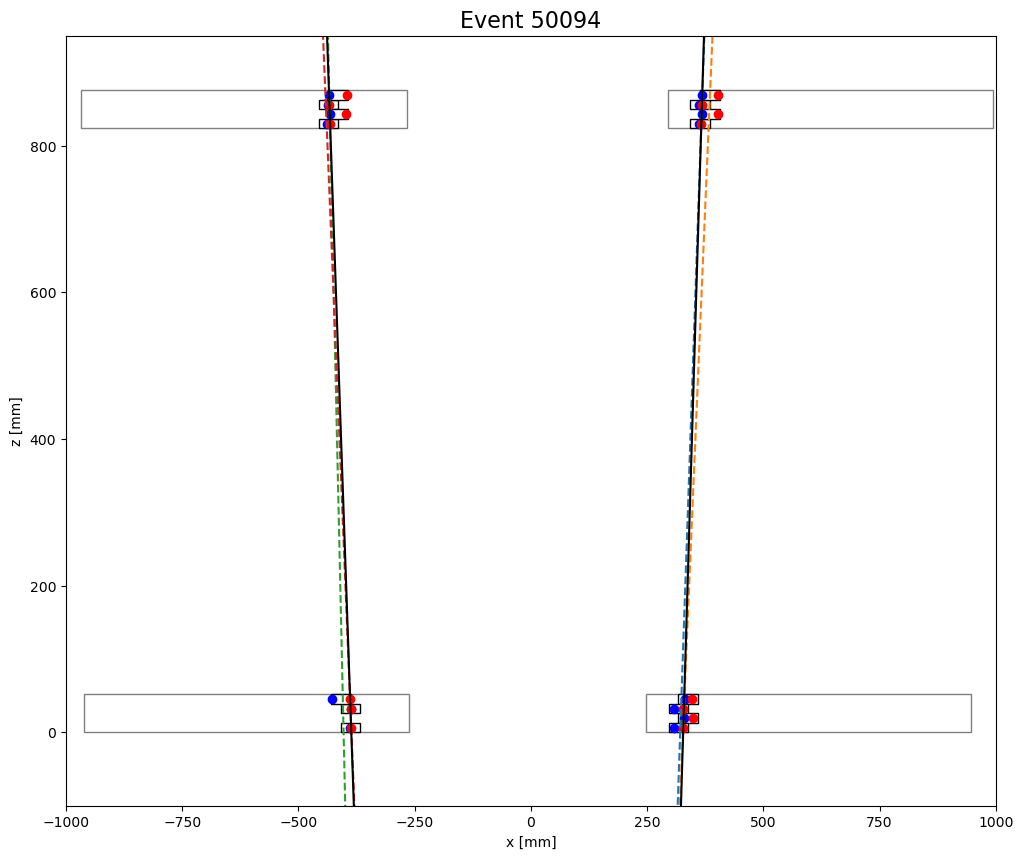

In [29]:
from matplotlib.patches import Rectangle
from scipy.stats import linregress

def event_plotter(event_number):
    my_event=cal1[event_number]
    x_centers, z_centers=(my_event['xlg']+my_event['xrg'])/2, my_event['zg']
    fig, ax=plt.subplots(figsize=(12,10))

    #drawing the detectors   
    for i in range(4):
        x_origs=np.array(global_x_shifts)-700
        z_origs=global_z_shifts
        detector=Rectangle([x_origs[i], z_origs[i]], 700, 4*ZCELL, edgecolor='gray', facecolor='white')
        ax.add_artist(detector)

    #drawing the triggered cells
    for i in range(len(my_event)):
        rect=Rectangle([x_centers[i]-XCELL/2, z_centers[i]-ZCELL/2], XCELL, ZCELL, edgecolor='black', facecolor='white')
        ax.add_artist(rect)

    ax.scatter(my_event['xlg'], my_event['zg'], color='blue')
    ax.scatter(my_event['xrg'], my_event['zg'], color='red')
    XRANGE=[-1000, 1000]
    YRANGE=[-100, 950]
    ax.set_xlim(XRANGE)
    ax.set_ylim(YRANGE)
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('z [mm]')
    ax.set_title(f'Event {event_number}', size=16)

    def tracker_fitter(in_line_chambers):
        print('chamber:', in_line_chambers[0])
        (xu,zu)=zip(*opt_track(my_event, in_line_chambers[0]))
        print('chamber:', in_line_chambers[1])
        (xd,zd)=zip(*opt_track(my_event, in_line_chambers[1]))
        x=np.concatenate([xu,xd])
        z=np.concatenate([zu,zd])

        resu=linregress(zu,xu)
        resd=linregress(zd,xd)
        res=linregress(z,x)

        xspace=np.linspace(*XRANGE, 1000)
        ax.plot(xspace, 1/resu.slope*xspace-resu.intercept/resu.slope, '--')
        ax.plot(xspace, 1/resd.slope*xspace-resd.intercept/resd.slope, '--')
        ax.plot(xspace, 1/res.slope*xspace-res.intercept/res.slope, color='black')

        #ax.plot(xu,zu)
        #ax.plot(xd,zd)
    
    for i in range(0,len(calib_config),2):
        tracker_fitter(calib_config[i:i+2])


    plt.show()
    my_event


for k in range(min([50, len(impeccable_events)])):
    print(k)
    print(impeccable_events[k])
    print(cal1[impeccable_events[k]])
    event_plotter(impeccable_events[k])
#event_plotter(4)

### Let's observe that the eighth hit of 51-th event of first calibration run (so maybe other ones too) not only presents xleft and xright farther apart than the width of a cell, but neither of the two isn't compatible with a fitting line for the trajectory